# PROPOSTA DE CRIAÇÃO DE METODOLOGIA DE ANÁLISE DE DADOS PARA APLICAÇÃO DE PEOPLE ANALYTICS EM DATASET DE ORGANIZAÇÃO DO SETOR DE TECNOLOGIA

# 1.0 Contexto

Projeto prático de People Analytics focado em um dos maiores desafios para as empresas: a rotatividade de funcionários (turnover). A perda de talentos gera custos significativos com novas contratações, treinamento e perda de conhecimento institucional.

Utilizando um conjunto de dados de RH, este projeto desenvolve um modelo de Machine Learning para prever a probabilidade de um funcionário deixar a empresa. O processo inclui desde a limpeza e análise exploratória dos dados até o treinamento e a avaliação de múltiplos algoritmos, culminando em um modelo otimizado capaz de identificar os colaboradores com maior risco de demissão. O objetivo final é fornecer uma ferramenta que permita ao RH agir de forma proativa para reter talentos valiosos.

# 2.0 Importação

Estes são os pacotes que estamos usando neste projeto, os quais foram separados por propósito.

In [1]:
# general utilities
import inflection
from unidecode import unidecode
import uuid

# data manipulation
import pandas as pd
import numpy as np

# Exploratory Data Analysis
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chi2_contingency

# preprocessing
from sklearn.preprocessing import MinMaxScaler

# feature selection
from boruta import BorutaPy

# machine learning
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# hyperparameter tuning
from scipy.stats import randint, uniform
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV

# model evaluation and calibration
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold

# metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, f1_score, precision_recall_curve, precision_score, recall_score, roc_auc_score, roc_curve

# 3.0 Funções auxiliares

Essas funções nos ajudam a ter uma experiência melhor na obtenção dos resultados.

In [2]:
def anonymize_employee_data(df_employee, colunas_dados_pessoais, nome_arquivo_identificacao):
    df_anonimizado = df_employee.copy()

    # 1. Adds an 'ID' column with a GUID (Globally Unique Identifier)
    df_anonimizado['ID'] = [uuid.uuid4() for _ in range(len(df_anonimizado))]

    # 2. Creates and saves the identification mapping file
    colunas_identificacao = ['ID'] + colunas_dados_pessoais
    df_identificacao = df_anonimizado[colunas_identificacao].copy()
    df_identificacao.to_csv(nome_arquivo_identificacao, index=False, encoding='utf-8-sig')
    print(f"Arquivo de mapeamento '{nome_arquivo_identificacao}' criado com sucesso.")

    # 3. Remove personal columns from the main DataFrame
    df_anonimizado.drop(columns=colunas_dados_pessoais, inplace=True)

    # 4. Rearrange columns so that 'ID' is first
    todas_as_colunas = ['ID'] + [col for col in df_anonimizado.columns if col != 'ID']
    df_anonimizado = df_anonimizado[todas_as_colunas]

    return df_anonimizado

def add_demand_offer_positions(df_employee, df_analise_cargo_mercado_trabalho):
    # Prepares the demand DataFrame by selecting and renaming the required column
    df_demanda_oferta_cargos = df_analise_cargo_mercado_trabalho[['Cargo', 'NivelCargo', 'DemandaOfertaVagas']].rename(
        columns={'DemandaOfertaVagas': 'DemandaOfertaVagasMercadoParaCargo'}
    )

    # Perform the merge
    df_merged = pd.merge(
        df_employee,
        df_demanda_oferta_cargos,
        on=['Cargo', 'NivelCargo'],
        how='left'
    )

    return df_merged

def add_market_salary_difference(df_employee, df_analise_cargo_mercado_trabalho):
    df_result = df_employee.copy()

    # 1. Create a lookup map with the market salary, using (Cargo, NivelCargo) as the key.
    market_salary_map = df_analise_cargo_mercado_trabalho.set_index(['Cargo', 'NivelCargo'])['Salario']

    # 2. Generates search keys (MultiIndex) from employee data.
    employee_lookup_keys = pd.MultiIndex.from_frame(df_result[['Cargo', 'NivelCargo']])

    # 3. Maps keys to get each employee's market salary.
    market_salaries = employee_lookup_keys.map(market_salary_map)

    # 4. Calculates the difference and adds it as a new column.
    df_result['DiferencaSalarialComMercadoParaMesmoCargoNivelExperiência'] = df_result['Salario'] - market_salaries

    return df_result

def add_dismissal_identifier_before_breakeven(df_employee, df_breakeven_cargo):
    df_result = df_employee.copy()

    # 1. Creates a search map for break-even months by position.
    breakeven_map = df_breakeven_cargo.set_index('Cargo')['MesesBreakEvenAcumulado']

    # 2. Get the break-even months for each employee's position.
    breakeven_months = df_result['Cargo'].map(breakeven_map)

    # 3. Calculates each employee's time with the company in months.
    employee_months_in_company = df_result['AnosEmpresa'] * 12

    # 4. Define the condition: was fired AND time at the company < months from break-even.
    condition = (df_result['Demitido'] == 'Sim') & (employee_months_in_company < breakeven_months)

    # 5. Applies the condition to create the new column.
    df_result['DemissaoAntesAtingirBreakEvenAcumulado'] = np.where(condition, 'Sim', 'Não')

    return df_result

def filter_employee_time_company_shorter_breakeven(df_employee, df_breakeven_cargo):
    # Create a copy to avoid modifying the original DataFrame
    df_filtrado = df_employee.copy()

    # Create a map for breakeven time by position
    breakeven_map = df_breakeven_cargo.set_index('Cargo')['MesesBreakEvenAcumulado']

    # Add a temporary column with the position's breakeven time
    df_filtrado['breakeven_cargo_meses'] = df_filtrado['Cargo'].map(breakeven_map)

    # Filter the DataFrame
    df_filtrado = df_filtrado[df_filtrado['AnosEmpresa'] * 12 <= df_filtrado['breakeven_cargo_meses']].copy()

    # Remove temporary column
    df_filtrado.drop('breakeven_cargo_meses', axis=1, inplace=True)

    return df_filtrado

def remove_special_characters(df):
    # Function to apply unidecode to strings
    def clean_text(text):
        if isinstance(text, str):
            return unidecode(text)
        return text

    # Creates a copy of the DataFrame so as not to modify the original
    df_clean = df.copy()

    # Applies the function to all columns of the DataFrame
    for col in df_clean.columns:
        # Rename columns by removing special characters
        new_col = unidecode(col)
        df_clean.rename(columns={col: new_col}, inplace=True)

        # Applies the function to all values in the column
        df_clean[new_col] = df_clean[new_col].apply(clean_text)

    return df_clean

def cramer_v(var_x, var_y):
    # builds contigency matrix (or confusion matrix)
    confusion_matrix = pd.crosstab(var_x, var_y).values

    # gets the sum of all values in the matrix
    n = confusion_matrix.sum()

    # gets the rows, cols
    r, k = confusion_matrix.shape

    # gets the chi-squared
    chi2 = chi2_contingency(confusion_matrix)[0]

    # makes the bias correction
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    kcorr = k - (k-1) ** 2 / (n-1)
    rcorr = r - (r-1) ** 2 / (n-1)

    # returns cramér V
    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))

def get_attribute_frequency(attribute):

    # creates a dictionary from value counts
    count_dict_attribute = attribute.value_counts().to_dict()

    # stores values as DataFrame
    df_count_attribute = pd.DataFrame(count_dict_attribute.items(), columns=['Value','Count'])

    # calculates the frequency for each value
    df_count_attribute['frequency'] = df_count_attribute['Count'] / df_count_attribute['Count'].sum()

    # gets a dictionary for the frequency
    frequency_attribute = df_count_attribute.set_index('Value').to_dict()['frequency']

    return frequency_attribute

def get_encoded_frequencies(data_frame):

    # creates an empty DataFrame
    encoded_freq = pd.DataFrame()

    # creates columns for frequency
    for column in data_frame.columns:
        encoded_freq[column] = data_frame[column].map(get_attribute_frequency(data_frame[column]))

    return encoded_freq

def calculate_model_metrics(y_test, model_probs, threshold):
    """
        Calculates Accuracy, F1-Score, PR AUC
    """
    # keeps probabilities for the positive outcome only
    probs = pd.DataFrame(model_probs[:, 1], columns=['prob'])

    # applies the threshold
    y_pred = probs['prob'].apply(lambda x: 1 if x > threshold else 0)

    # calculates f1-score
    f1 = f1_score(y_test, y_pred)

    # calculates accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # calculates kappa score
    kappa = cohen_kappa_score(y_test, y_pred)

    # calculates AUC
    auc_score = roc_auc_score(y_test, probs)

    # calculates the precision
    precision = precision_score(y_test, y_pred)

    # calculates the recall
    recall = recall_score(y_test, y_pred)

    return accuracy, kappa, f1, auc_score, precision, recall

def get_classifiers_performance(X_train, X_test, y_train, y_test, threshold, classifiers):

    # creates empty data frame
    df_performance = pd.DataFrame()

    for clf in classifiers:
        print("Training " + type(clf).__name__ + "...")
        # fits the classifier to training data
        clf.fit(X_train, y_train)

        # predict the probabilities
        clf_probs = clf.predict_proba(X_test)

        # calculates model metrics
        clf_accuracy, clf_kappa, clf_f1, clf_auc, clf_precision, clf_recall = calculate_model_metrics(y_test, clf_probs, threshold)

        # creates a dict
        clf_dict = {
            'model': [type(clf).__name__, '---'],
            'precision': [clf_precision, np.nan],
            'recall': [clf_recall, np.nan],
            'f1-Score': [clf_f1, np.nan],
            'ROC AUC': [clf_auc, np.nan],
            'accuracy': [clf_accuracy, np.nan],
            'cohen kappa': [clf_kappa, np.nan]}

        # concatenate Data Frames
        df_performance = pd.concat([df_performance, pd.DataFrame(clf_dict)])

    # resets Data Frame index
    df_performance = df_performance.reset_index()

    # drops index
    df_performance.drop('index', axis=1, inplace=True)

    # gets only the odd numbered rows
    rows_to_drop = np.arange(1, len(classifiers)*2, 2)

    # drops unwanted rows that have no data
    df_performance.drop(rows_to_drop, inplace=True)

    # returns performance summary
    return df_performance

def plot_single_confusion_matrix(y_test, y_pred, model, qualifier=""):
    # calculates confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # plots confusion matrix as heatmap
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap='viridis',
                     square=True, annot_kws={"size": 14})

    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    ax.title.set_text(type(model).__name__ + ' ' + str(qualifier))

def plot_multiple_confusion_matrices(n_rows, n_cols, X_test, y_test, classifiers, threshold):
    # define subplots
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 10))

    for clf, ax, n in zip(classifiers, ax.flatten(), list(range(n_rows*n_cols))):

        # predict the probabilities
        clf_probs = clf.predict_proba(X_test)

        # keeps probabilities for the positive outcome only
        probs = pd.DataFrame(clf_probs[:, 1], columns=['prob_default'])

        # applied the threshold
        y_pred = probs['prob_default'].apply(
            lambda x: 1 if x > threshold else 0)

        # plots confusion matrix as heatmap
        plt.subplot(n_rows, n_cols, n+1)
        plot_single_confusion_matrix(y_test, y_pred, clf)

    # adjusts subplot
    plt.tight_layout()

    # displays the plot
    plt.show()

def plot_pr_auc(y_test, model_probs, model_name):
    """
        Plots PR AUC curve
    """

    # keep probabilities for the positive outcome only
    probs = model_probs[:, 1]

    # calculate precision and recall for each threshold
    precision, recall, _ = precision_recall_curve(y_test, probs)

    # calculates the no-skill baseline
    no_skill = len(y_test[y_test == 1]) / len(y_test)

    # plots the curve
    plt.plot([0, 1], [no_skill, no_skill],
             linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label=model_name)

    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')

    # title
    plt.title('PR Curve - ' + model_name, fontsize=14)

    # show the legend
    plt.legend()

    # displays the plot
    plt.show()

# 4.0 Verificando o conjunto de dados

## 4.1 Dicionário de Dados

**Conjunto de dados: Análise de RH, Perda de Funcionário e Desempenho**

Conjunto de dados original: https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset

Este é um conjunto de dados fictício criado por um aluno da UFSC (Universidade Federal de Santa Catarina) com base em um conjunto de dados criado por cientistas de dados da IBM. Como não há uma descrição para todos os recursos, interpretei todos eles:


| Nome do atributo                                          | Tipo de dado | Descrição                                                                                                                                                                                                                                                     |
|:----------------------------------------------------------|:------------:|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Matricula                                                 |    int64     | Identificador único do funcionário                                                                                                                                                                                                                            |
| Nome                                                      |    object    | Nome completo do funcionário                                                                                                                                                                                                                                  |
| CPF                                                       |    object    | Cadastro de Pessoa Física do funcionário                                                                                                                                                                                                                      |
| Idade                                                     |    int64     | Idade do funcionário em anos                                                                                                                                                                                                                                  |
| Genero                                                    |    object    | Gênero do funcionário \(Feminino ; Masculino\)                                                                                                                                                                                                                |
| EstadoCivil                                               |    object    | Estado civil do funcionário \(Solteiro; Casado; Divorciado\)                                                                                                                                                                                                  |
| PortadorNecessidadesEspeciais                             |    object    | Indica se o funcionário é portador de necessidades especiais \(Sim; Não\)                                                                                                                                                                                     |
| PossuiCriancaMenorQue4anos                                |    object    | Indica se o funcionário possui filhos menores de 4 anos \(Sim; Não\)                                                                                                                                                                                          |
| GrauEscolaridade                                          |    int64     | Nível de escolaridade do funcionário \(1 = Ensino médio ou abaixo; 2 = Ensino superior; 3 = Especialização; 4 = Mestrado; 5 = Doutorado\)                                                                                                                     |
| AreaFormacao                                              |    object    | Área de formação do funcionário \(Ciência da Computação; Bioinformática; Marketing; Curso Técnico; Recursos Humanos; Outros\)                                                                                                                                 |
| TreinamentoUltimoAno                                      |    int64     | Total de vezes que o funcionário teve uma sessão de treinamento no último ano                                                                                                                                                                                 |
| Cargo                                                     |    object    | Função do funcionário \(Executivo(a) de Contas; Engenheiro(a) de Machine Learning; Analista de QA; Diretor(a) de Operações; Arquiteto(a) de Soluções; Gerente de Projetos; SDR (Sales Development Representative); Diretor(a) de Tecnologia; Analista de RH\) |
| NivelCargo                                                |    int64     | Nível de cargo do funcionário \(1 = Júnior; 2 = Pleno; 3 = Sênior; 4 = Gerente; 5 = Diretor\)                                                                                                                                                                 |
| AnosEmpresa                                               |    int64     | Total de anos que o funcionário trabalhou na empresa                                                                                                                                                                                                          |
| AnosCargoAtual                                            |    int64     | Total de anos que o funcionário trabalhou em sua função atual                                                                                                                                                                                                 |
| TipoProjeto                                               |    object    | Tipo de projeto em que o funcionário está envolvido \(Inovação; Sustentação; Outros\)                                                                                                                                                                         |
| HorarioFlexivel                                           |    object    | Indica se o funcionário tem horário flexível \(Sim; Não\)                                                                                                                                                                                                     |
| ViagemNegocios                                            |    object    | Com que frequência o funcionário viaja a negócios (Viaja\_Raramente; Viaja\_Frequentemente; Não\-Viaja)                                                                                                                                                       |
| OportunidadeUsarPlenamenteHabilidadesTrabalho             |    int64     | Avaliação do funcionário sobre a oportunidade de usar plenamente suas habilidades no trabalho \(1 = Pouco; 2 = Razoavelmente; 3 = Consideravelmente; 4 = Completamente\)                                                                                      |
| Departmento                                               |    object    | A qual departamento o funcionário pertence \(Vendas; Pesquisa e Desenvolvimento (P&D); Recursos Humanos\)                                                                                                                                                     |
| AnosAtualGestor                                           |    int64     | Total de anos que o funcionário trabalhou sob seu gerente atual                                                                                                                                                                                               |
| Salario                                                   |   float64    | Renda mensal do funcionário em Real                                                                                                                                                                                                                           |
| PercepcaoValorBeneficios                                  |    int64     | Percepção de valor pelo colaborador dos benefícios pagos pela empresa (Vale alimentação, Plano de Saúde, Vale academia, dentre outros) \(1 = Baixo; 2 = Médio; 3 = Alto; 4 = Muito Alto\)                                                                     |
| AnosDesdeUltimaPromocao                                   |    int64     | Total de anos desde que o funcionário teve sua última promoção na empresa                                                                                                                                                                                     |
| RecebeuParticipacaoLucrosResultadosUltimos3anos           |    object    | Indica se o funcionário recebeu participação nos lucros/resultados nos últimos 3 anos \(Sim; Não\)                                                                                                                                                            |
| DistanciaCasa                                             |    int64     | A que distância o funcionário mora do trabalho em quilômetros                                                                                                                                                                                                 |
| TipoTransporte                                            |    object    | Meio de transporte utilizado pelo funcionário para ir ao trabalho \(Carro Próprio; Transporte Público; Outros\)                                                                                                                                               |
| ModalidadeTrabalho                                        |    object    | Modalidade de trabalho do funcionário \(Presencial; Remoto\)                                                                                                                                                                                                  |
| SatisfacaoGestor                                          |    int64     | Quão satisfeito o funcionário se sente com o relacionamento com seu gerente \(1 = Baixo; 2 = Médio; 3 = Alto; 4 = Muito Alto\)                                                                                                                                |
| SatisfacaoRelacionamentoColegas                           |    int64     | Quão satisfeito o funcionário se sente com o relacionamento com seus colegas \(1 = Baixo; 2 = Médio; 3 = Alto; 4 = Muito Alto\)                                                                                                                               |
| SatisfaçãoTrabalho                                        |    int64     | Quão satisfeito o funcionário se sente com seu trabalho \(1 = Baixo; 2 = Médio; 3 = Alto; 4 = Muito Alto\)                                                                                                                                                    |
| NívelEnvolvimentoTrabalho                                 |    int64     | Quão envolvido o funcionário se sente com seu trabalho \(1 = Baixo; 2 = Médio; 3 = Alto; 4 = Muito Alto\)                                                                                                                                                     |
| AvaliacaoDesempenho                                       |    int64     | Classificação de desempenho do funcionário \(1 = Baixo; 2 = Bom; 3 = Excelente; 4 = Extraordinário\)                                                                                                                                                          |
| Absenteismo                                               |    int64     | Indica o percentual de ausência do funcionário no trabalho em relação aos dias trabalhados                                                                                                                                                                    |
| HoraExtra                                                 |    object    | Se o funcionário fizer horas extras \(Sim ; Não\)                                                                                                                                                                                                             |
| EquilíbrioEntreVidaProfissionalPessoal                    |    int64     | Como o funcionário se sente em relação ao equilíbrio entre vida profissional e pessoal \(1 = Ruim; 2 = Bom; 3 = Melhor; 4 = Ótimo\)                                                                                                                           |
| DemandaOfertaVagasMercadoParaCargo                        |    int64     | Avaliação da demanda e oferta de vagas no mercado para o cargo do funcionário \(1 = Baixo; 2 = Médio; 3 = Alto; 4 = Muito Alto\)                                                                                                                              |
| DiferencaSalarialComMercadoParaMesmoCargoNivelExperiência |   float64    | Diferença salarial eentre o valor do salário de mercado para o mesmo cargo e nível de experiência do funcionário e o atualmente recebido pelo funcionário \(em Real\)                                                                                         |
| Demitido                                                  |    object    | Indica se o funcionário saiu da empresa de forma voluntária \(Sim ; Não\)                                                                                                                                                                                     |
| DemissaoAntesAtingirBreakEvenAcumulado                    |    object    | Indica se o funcionário pediu demissão voluntária antes de atingir o ponto de equilíbrio (break-even) acumulado \(Sim; Não\)                                                                                                                                  |


**Análise de Cargo no Mercado de Trabalho**

A tabela permite a análise de cargos, seus níveis hierárquicos, faixas salariais e a correspondente demanda no mercado de trabalho.

O objetivo destas informações é avaliar o impacto na demissão do funcionário, conforme salário, oferta e demanda do cargo no mercado de trabalho.

| Nome do atributo                   | Tipo de dado | Descrição                                                                                                                                                                                                                                                     |
|:-----------------------------------|:------------:|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Cargo                              |    object    | Função do funcionário \(Executivo(a) de Contas; Engenheiro(a) de Machine Learning; Analista de QA; Diretor(a) de Operações; Arquiteto(a) de Soluções; Gerente de Projetos; SDR (Sales Development Representative); Diretor(a) de Tecnologia; Analista de RH\) |
| NivelCargo                         |    int64     | Nível de cargo do funcionário \(1 = Júnior; 2 = Pleno; 3 = Sênior; 4 = Gerente; 5 = Diretor\)                                                                                                                                                                 |
| Salario                            |   float64    | Estimativa do salário mensal de mercado para o cargo e nível de cargo \(em Real\)                                                                                                                                                                             |
| DemandaOfertaVagasMercadoParaCargo |    int64     | Avaliação da demanda e oferta de vagas no mercado para o cargo \(1 = Baixo; 2 = Médio; 3 = Alto; 4 = Muito Alto\)                                                                                                                                             |


**Breakeven do Cargo**

A tabela apresenta uma estrutura de dados focada na análise do retorno sobre o investimento baseado no cargo dos funcionários.

Esta estrutura de dados permite avaliar a eficiência financeira e o tempo de retorno associado a cada cargo na organização.

| Nome do atributo                                          | Tipo de dado | Descrição                                                                                                                                                                                                                                                     |
|:----------------------------------------------------------|:------------:|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Cargo                                                     |    object    | Função do funcionário \(Executivo(a) de Contas; Engenheiro(a) de Machine Learning; Analista de QA; Diretor(a) de Operações; Arquiteto(a) de Soluções; Gerente de Projetos; SDR (Sales Development Representative); Diretor(a) de Tecnologia; Analista de RH\) |
| MesesBreakEven                                            |    int64     | Quantidade de meses para atingir o ponto de equilíbrio (break-even) de investimento no funcionário                                                                                                                                                            |
| MesesBreakEvenAcumulado                                   |    int64     | Quantidade acumulada de meses para atingir o ponto de equilíbrio (break-even) de investimento no funcionário                                                                                                                                                  |


## 4.2 Variáveis Globais

**SEED**
O que é: Uma "semente" para o gerador de números aleatórios.
Impacto no Projeto: Garante a reprodutibilidade dos resultados. Operações com componentes aleatórios, como a divisão dos dados entre treino e teste ou a inicialização de certos modelos (como o RandomForest), sempre produzirão o mesmo resultado se o SEED for o mesmo. Isso é fundamental para que os experimentos sejam consistentes e comparáveis.

**THRESHOLD**
O que é: O ponto de corte para a decisão do modelo. Modelos de classificação geralmente preveem uma probabilidade (ex: 70% de chance de demissão). O threshold converte essa probabilidade em uma classificação binária (Sim/Não).
Impacto no Projeto: Afeta diretamente a sensibilidade do modelo. Se a probabilidade prevista for maior que 0.5, o funcionário será classificado como "propenso a sair". Um valor menor (ex: 0.4) identificaria mais demissões potenciais (aumentando o Recall), mas com o risco de mais falsos positivos. Um valor maior seria mais conservador.

**ANALISAR_SOMENTE_FUNCIONARIOS_TEMPO_EMPRESA_MENOR_BREAKEVEN**
O que é: Um filtro para a base de dados. "Breakeven" aqui se refere ao ponto em que o funcionário "se pagou", ou seja, o valor que ele gerou superou os custos de sua contratação e treinamento.
Impacto no Projeto: Como está definido como False, o projeto atualmente analisa todos os funcionários da base. Se fosse True, o estudo se concentraria apenas em funcionários mais novos, que ainda não atingiram esse ponto de equilíbrio, focando a análise no problema do turnover precoce.

**MODEL_SELECTED**
O que é: Define qual algoritmo de Machine Learning será utilizado.
Impacto no Projeto: É uma das variáveis mais importantes. Ela dita a técnica de modelagem. A escolha por "RandomForestClassifier" significa usar um modelo de conjunto (ensemble) robusto e de alta performance. Alterar para "LogisticRegression", por exemplo, mudaria para um modelo mais simples e interpretável, com resultados e características diferentes.

**PREVER_SOMENTE_DEMISSAO_ANTES_ATINGIR_BREAKEVEN_ACUMULADO**
O que é: Um seletor que define o objetivo principal do negócio.
Impacto no Projeto: É a variável mais estratégica. Como está True, o modelo não tentará prever qualquer demissão, mas sim um tipo específico e muito custoso: a demissão que ocorre antes que o funcionário gere retorno sobre o investimento. Isso foca o projeto em resolver o problema de maior impacto financeiro para a área de RH. Se fosse False, o objetivo seria mais genérico.

**VARIAVEL_ALVO**
O que é: O nome da coluna que o modelo deve aprender a prever.
Impacto no Projeto: Seu valor é uma consequência direta da variável anterior. Como PREVER_SOMENTE... é True, a variável alvo será "DemissaoAntesAtingirBreakEvenAcumulado". Isso alinha todo o processo de treinamento e avaliação para focar no objetivo de prever o turnover precoce, garantindo que o modelo esteja resolvendo o problema de negócio correto.

In [3]:
# defines global variables
SEED = 42
THRESHOLD = 0.5
ANALISAR_SOMENTE_FUNCIONARIOS_TEMPO_EMPRESA_MENOR_BREAKEVEN = False
MODEL_SELECTED = "RandomForestClassifier" # LogisticRegression | RandomForestClassifier | XGBClassifier | LGBMClassifier
PREVER_SOMENTE_DEMISSAO_ANTES_ATINGIR_BREAKEVEN_ACUMULADO = True
VARIAVEL_ALVO = "DemissaoAntesAtingirBreakEvenAcumulado" if PREVER_SOMENTE_DEMISSAO_ANTES_ATINGIR_BREAKEVEN_ACUMULADO else "Demitido"

## 4.3 Carregando conjunto de dados

In [4]:
# loads data set
df_employee = pd.read_csv('data/colaboradores.csv', low_memory=False)

df_analise_cargo_mercado_trabalho = pd.read_csv('data/analise_cargo_mercado_trabalho.csv', low_memory=False)

df_breakeven_cargo = pd.read_csv('data/breakeven_cargo.csv', low_memory=False)

In [5]:
df_employee = anonymize_employee_data(df_employee, ['Matricula', 'Nome', 'CPF'], 'identificacao_funcionarios.csv')

Arquivo de mapeamento 'identificacao_funcionarios.csv' criado com sucesso.


In [6]:
df_employee = add_demand_offer_positions(df_employee, df_analise_cargo_mercado_trabalho)

df_employee = add_market_salary_difference(df_employee, df_analise_cargo_mercado_trabalho)

if PREVER_SOMENTE_DEMISSAO_ANTES_ATINGIR_BREAKEVEN_ACUMULADO:
    df_employee = add_dismissal_identifier_before_breakeven(df_employee, df_breakeven_cargo)

In [7]:
if ANALISAR_SOMENTE_FUNCIONARIOS_TEMPO_EMPRESA_MENOR_BREAKEVEN:
    df_employee = filter_employee_time_company_shorter_breakeven(df_employee, df_breakeven_cargo)

In [8]:
df_employee

,ID,Idade,Genero,EstadoCivil,PortadorNecessidadesEspeciais,PossuiCriancaMenorQue4anos,GrauEscolaridade,AreaFormacao,TreinamentoUltimoAno,Cargo,...,SatisfaçãoTrabalho,NívelEnvolvimentoTrabalho,AvaliacaoDesempenho,Absenteismo,HoraExtra,EquilíbrioEntreVidaProfissionalPessoal,Demitido,DemandaOfertaVagasMercadoParaCargo,DiferencaSalarialComMercadoParaMesmoCargoNivelExperiência,DemissaoAntesAtingirBreakEvenAcumulado
0,5732dce5-1182-4ee6-80d9-eff46088a7ea,58,Feminino,Casado,Não,Não,4,Bioinformática,3,Arquiteto(a) de Soluções,...,4,3,3,4,Não,2,Sim,4,-1688.0,Não
1,d3701f4f-c71f-45e5-9b28-18ee9e94e8e7,58,Masculino,Solteiro,Não,Não,4,Bioinformática,1,Executivo(a) de Contas,...,3,3,3,3,Não,2,Não,2,1872.0,Não
2,bcc4fbf8-ffb1-4a73-9092-62ab112c0e8e,55,Masculino,Solteiro,Não,Não,3,Bioinformática,2,Gerente de Projetos,...,1,3,3,0,Sim,3,Não,2,1045.0,Não
3,25a67e8a-a13f-4531-874a-ab88b614ad77,55,Masculino,Casado,Não,Não,5,Marketing,3,Gerente de Projetos,...,4,2,4,0,Não,3,Não,2,1586.0,Não
4,5b04682d-083b-413b-b02b-0d01d35a24ee,52,Masculino,Casado,Não,Não,4,Marketing,3,Gerente de Projetos,...,1,2,3,0,Não,4,Não,2,1856.0,Não
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,f4124f83-ca06-4e82-b755-213bb74fdb42,23,Masculino,Casado,Não,Não,3,Ciência da Computação,2,Analista de QA,...,1,4,4,0,Sim,3,Sim,3,-1278.8,Sim
1466,0e3d452d-13b4-4f85-b590-870cc4256c41,44,Masculino,Solteiro,Não,Não,3,Ciência da Computação,3,Engenheiro(a) de Machine Learning,...,3,1,3,4,Não,3,Sim,4,-2023.0,Sim
1467,dcf5194f-1ba7-4e41-9bc8-7553e0d61a93,18,Masculino,Solteiro,Não,Não,3,Marketing,3,SDR (Sales Development Representative),...,2,3,3,0,Sim,3,Não,2,-746.4,Não
1468,6747aaae-3078-4500-9ede-227f444ab39d,28,Masculino,Solteiro,Não,Não,4,Ciência da Computação,5,Analista de QA,...,3,3,3,0,Não,1,Sim,3,982.0,Sim


## 4.4 Renomeando colunas

In [9]:
 # check the data set columns
df_employee.columns

Index(['ID', 'Idade', 'Genero', 'EstadoCivil', 'PortadorNecessidadesEspeciais',
       'PossuiCriancaMenorQue4anos', 'GrauEscolaridade', 'AreaFormacao',
       'TreinamentoUltimoAno', 'Cargo', 'NivelCargo', 'AnosEmpresa',
       'AnosCargoAtual', 'TipoProjeto', 'HorarioFlexivel', 'ViagemNegocios',
       'OportunidadeUsarPlenamenteHabilidadesTrabalho', 'Departamento',
       'AnosAtualGestor', 'Salario', 'PercepcaoValorBeneficios',
       'AnosDesdeUltimaPromocao',
       'RecebeuParticipacaoLucrosResultadosUltimos3anos', 'DistanciaCasa',
       'TipoTransporte', 'Remoto', 'SatisfacaoGestor',
       'SatisfacaoRelacionamentoColegas', 'SatisfaçãoTrabalho',
       'NívelEnvolvimentoTrabalho', 'AvaliacaoDesempenho', 'Absenteismo',
       'HoraExtra', 'EquilíbrioEntreVidaProfissionalPessoal', 'Demitido',
       'DemandaOfertaVagasMercadoParaCargo',
       'DiferencaSalarialComMercadoParaMesmoCargoNivelExperiência',
       'DemissaoAntesAtingirBreakEvenAcumulado'],
      dtype='object')

In [10]:
# stores the old column names
cols_old = ['ID', 'Idade', 'Genero', 'EstadoCivil', 'PortadorNecessidadesEspeciais',
       'PossuiCriancaMenorQue4anos', 'GrauEscolaridade', 'AreaFormacao',
       'TreinamentoUltimoAno', 'Cargo', 'NivelCargo', 'AnosEmpresa',
       'AnosCargoAtual', 'TipoProjeto', 'HorarioFlexivel', 'ViagemNegocios',
       'OportunidadeUsarPlenamenteHabilidadesTrabalho', 'Departamento',
       'AnosAtualGestor', 'Salario', 'PercepcaoValorBeneficios',
       'AnosDesdeUltimaPromocao',
       'RecebeuParticipacaoLucrosResultadosUltimos3anos', 'DistanciaCasa',
       'TipoTransporte', 'ModalidadeTrabalho', 'SatisfacaoGestor',
       'SatisfacaoRelacionamentoColegas', 'SatisfaçãoTrabalho',
       'NívelEnvolvimentoTrabalho', 'AvaliacaoDesempenho', 'Absenteismo',
       'HoraExtra', 'EquilíbrioEntreVidaProfissionalPessoal', 'Demitido',
       'DemandaOfertaVagasMercadoParaCargo',
       'DiferencaSalarialComMercadoParaMesmoCargoNivelExperiência']

if PREVER_SOMENTE_DEMISSAO_ANTES_ATINGIR_BREAKEVEN_ACUMULADO:
    cols_old.append('DemissaoAntesAtingirBreakEvenAcumulado')

# snake case
snakecase = lambda x: inflection.underscore(x)

# creates new columns from old columns in snakecase
cols_new = list(map(snakecase, cols_old))

# renames the old columns
df_employee.columns = cols_new

# removes special chars
df_employee = remove_special_characters(df_employee)

# additional: also convert VARIAVEL_ALVO to snakecase
VARIAVEL_ALVO = snakecase(VARIAVEL_ALVO)

In [11]:
# check the operation
df_employee.columns

Index(['id', 'idade', 'genero', 'estado_civil',
       'portador_necessidades_especiais', 'possui_crianca_menor_que4anos',
       'grau_escolaridade', 'area_formacao', 'treinamento_ultimo_ano', 'cargo',
       'nivel_cargo', 'anos_empresa', 'anos_cargo_atual', 'tipo_projeto',
       'horario_flexivel', 'viagem_negocios',
       'oportunidade_usar_plenamente_habilidades_trabalho', 'departamento',
       'anos_atual_gestor', 'salario', 'percepcao_valor_beneficios',
       'anos_desde_ultima_promocao',
       'recebeu_participacao_lucros_resultados_ultimos3anos', 'distancia_casa',
       'tipo_transporte', 'modalidade_trabalho', 'satisfacao_gestor',
       'satisfacao_relacionamento_colegas', 'satisfacao_trabalho',
       'nivel_envolvimento_trabalho', 'avaliacao_desempenho', 'absenteismo',
       'hora_extra', 'equilibrio_entre_vida_profissional_pessoal', 'demitido',
       'demanda_oferta_vagas_mercado_para_cargo',
       'diferenca_salarial_com_mercado_para_mesmo_cargo_nivel_experienci

## 4.5 Verificando dimensões de dados

In [12]:
print('Número de linhas: {}'.format(df_employee.shape[0]))
print('Número de colunas: {}'.format(df_employee.shape[1]))

Número de linhas: 1470
Número de colunas: 38


## 4.6 Verificando tipos de dados

In [13]:
# check data types in data set
df_employee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 38 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   id                                                                 1470 non-null   object 
 1   idade                                                              1470 non-null   int64  
 2   genero                                                             1470 non-null   object 
 3   estado_civil                                                       1470 non-null   object 
 4   portador_necessidades_especiais                                    1470 non-null   object 
 5   possui_crianca_menor_que4anos                                      1470 non-null   object 
 6   grau_escolaridade                                                  1470 non-null   int64  
 7   area_formacao           

In [14]:
# counts the number of each dtype
df_employee.dtypes.value_counts()

int64      19
object     17
float64     2
Name: count, dtype: int64

## 4.7 Verificando dados faltantes

In [15]:
df_employee.isna().sum()

id                                                                   0
idade                                                                0
genero                                                               0
estado_civil                                                         0
portador_necessidades_especiais                                      0
possui_crianca_menor_que4anos                                        0
grau_escolaridade                                                    0
area_formacao                                                        0
treinamento_ultimo_ano                                               0
cargo                                                                0
nivel_cargo                                                          0
anos_empresa                                                         0
anos_cargo_atual                                                     0
tipo_projeto                                                         0
horari

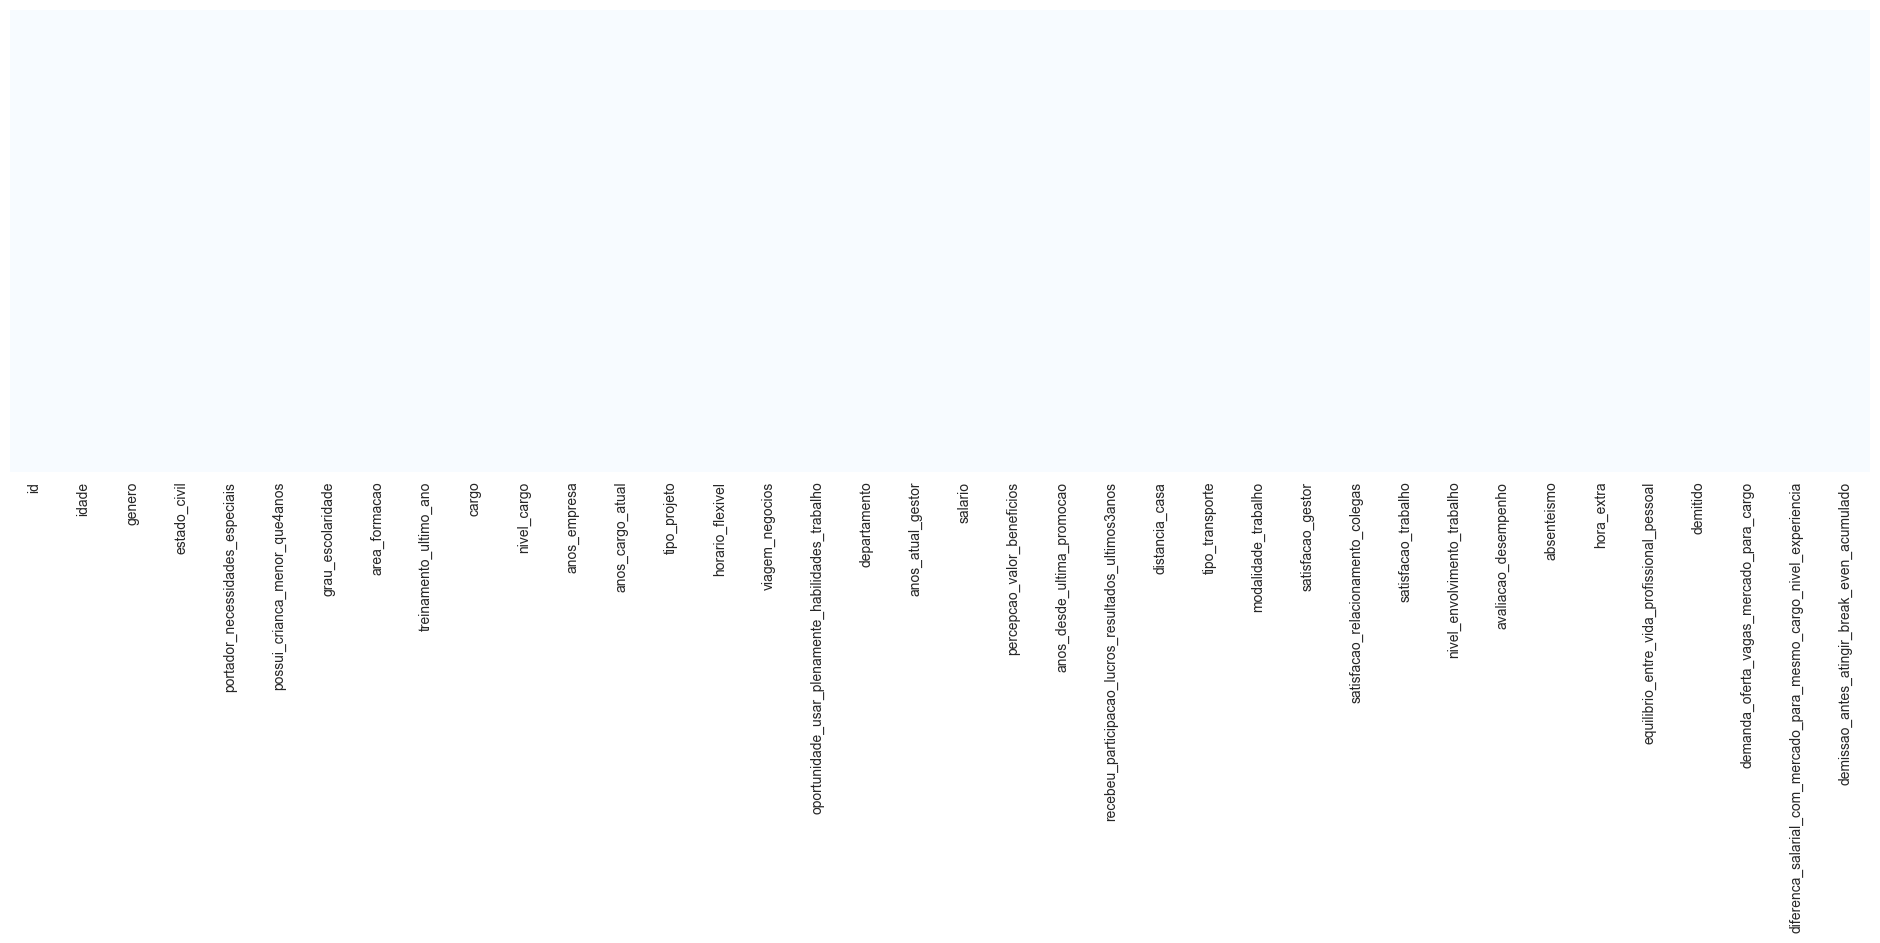

In [16]:
# Let's see if we have any missing data
plt.figure(figsize=(24, 6))
_ = sns.heatmap(df_employee.isnull(), yticklabels=False, cbar=False, cmap='Blues')

## 4.8 Estatísticas descritivas

In [17]:
# creates a dataset for numerical attributes
num_attributes = df_employee.select_dtypes(include=['int64', 'float64'])

# creates a dataset for categorical attributes
cat_attributes = df_employee.select_dtypes(exclude=['int64', 'float64'])

In [18]:
# central tendency: mean, median
mean = pd.DataFrame(num_attributes.apply(np.mean)).T
median = pd.DataFrame(num_attributes.apply(np.median)).T

# distribution: std, min, max, range, skew, kurtosis
std = pd.DataFrame(num_attributes.apply(np.std)).T
min_value = pd.DataFrame(num_attributes.apply(min)).T
max_value = pd.DataFrame(num_attributes.apply(max)).T
range_value = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
skewness = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenates
summary_stats = pd.concat([min_value, max_value, range_value, mean, median, std, skewness, kurtosis]).T.reset_index()
summary_stats.columns = [
 'attributes (Nome das variáveis)',
 'min (Valor mínimo)',
 'max (Valor máximo)',
 'range (Amplitude)',
 'mean (Média)',
 'median (Mediana)',
 'std (Desvio padrão)',
 'skewness (Assimetria)',
 'kurtosis (Curtose: Achatamento)']

In [19]:
# checking the operations
summary_stats

,attributes (Nome das variáveis),min (Valor mínimo),max (Valor máximo),range (Amplitude),mean (Média),median (Mediana),std (Desvio padrão),skewness (Assimetria),kurtosis (Curtose: Achatamento)
0,idade,18.0,60.0,42.0,36.923810,36.0,9.132266,0.413286,-0.404145
1,grau_escolaridade,1.0,5.0,4.0,2.912925,3.0,1.023817,-0.289681,-0.559115
2,treinamento_ultimo_ano,0.0,6.0,6.0,2.799320,3.0,1.288832,0.553124,0.494993
3,nivel_cargo,1.0,5.0,4.0,2.063946,2.0,1.106563,1.025401,0.399152
4,anos_empresa,0.0,40.0,40.0,7.008163,5.0,6.124441,1.764529,3.935509
5,anos_cargo_atual,0.0,18.0,18.0,4.229252,3.0,3.621904,0.917363,0.477421
6,oportunidade_usar_plenamente_habilidades_trabalho,1.0,4.0,3.0,2.658503,3.0,0.945656,-0.171271,-0.882811
7,anos_atual_gestor,0.0,17.0,17.0,4.123129,3.0,3.566922,0.833451,0.171058
8,salario,1262.4,25964.9,24702.5,7639.009442,5705.3,5406.703465,1.388384,1.234326
9,percepcao_valor_beneficios,1.0,4.0,3.0,2.502041,3.0,1.117424,-0.013904,-1.359053


## 4.9 Atributos categóricos

In [20]:
# checks how many types we have for each atribute
cat_attributes.apply(lambda x: x.unique().shape[0])

id                                                     1470
genero                                                    2
estado_civil                                              3
portador_necessidades_especiais                           2
possui_crianca_menor_que4anos                             2
area_formacao                                             6
cargo                                                     9
tipo_projeto                                              3
horario_flexivel                                          2
viagem_negocios                                           3
departamento                                              3
recebeu_participacao_lucros_resultados_ultimos3anos       1
tipo_transporte                                           3
modalidade_trabalho                                       2
hora_extra                                                2
demitido                                                  2
demissao_antes_atingir_break_even_acumul

## 4.10 Variável alvo

In [21]:
# counts how many of each class we have
df_employee[VARIAVEL_ALVO].value_counts()

demissao_antes_atingir_break_even_acumulado
Nao    1349
Sim     121
Name: count, dtype: int64

Como observado, estamos lidando com um conjunto de dados desbalanceado.

## 4.11 Checkpoint

In [22]:
# saves the current data set state
df_employee.to_csv('colaboradores_clean.csv', index=False)

# 5.0 Delineando as hipóteses

## 5.1 Mapa mental de hipóteses

![](img/Hipóteses.jpg)

## 5.2 Criando hipóteses

### 5.2.1 Modalidade de Trabalho

1. Funcionários vinculados a modalidade de trabalho presencial possuem maior tendência de pedir demissão

### 5.2.2 Tipo de Projeto

1. Funcionários que estão vinulados a projetos de 'Sustentação' possuem maior tendência de pedir demissão

### 5.2.3 Oportunidade de usar plenamente as habilidades no trabalho

1. Funcionários que utilizam pouco ou apenas razoavelmente suas habilidades no trabalho possuem maior tendência de pedir demissão

### 5.2.4 Anos desde a Última Promoção

1. Funcionários que estão há três anos ou mais sem promoção possuem maior tendência de pedir demissão

### 5.2.5 Satisfação no Trabalho

1. Funcionários que possuem satisfação com o trabalho baixa possuem maior tendência de pedir demissão

### 5.2.6 Demanda e Oferta de Vagas no Mercado para o Cargo

1. Quando a demanda e oferta no mercado de trabalho está alta ou muito alta para o cargo do funcionário, os mesmos possuem maior tendência de pedir demissão

### 5.2.7 Salário de mercado para o mesmo cargo e nível de experiência

1. Quando o salário de mercado for maior que o recebido atualmente pelo funcionário, o mesmos possui maior tendência de pedir demissão

### 5.2.8 Percepção de valor pelo colaborador dos benefícios pagos pela empresa

1. Funcionários que possuem percepção de valor baixo dos benefícios recebidos pela empresa (Vale alimentação, Plano de Saúde, Vale academia, dentre outros) possuem maior tendência de pedir demissão

# 6.0 Engenharia de Recursos (Feature Engineering)

## 6.1 Carregando conjunto de dados

In [23]:
# loads data set
df_employee = pd.read_csv('colaboradores_clean.csv')

## 6.2 Filtragem de colunas

Realizado a exclusão das colunas 'matricula', 'nome' e 'cpf' porque as mesmas são identificadores que não contribuirão para a análise.

Realizado também a exclusão da coluna 'recebeu_participacao_lucros_resultados_ultimos3anos' devido a todos os registros possuírem valor Nao, logo não há impacto na análise.

Caso a variável PEDIR_DEMISSAO_ANTES_ATINGIR_BREAKEVEN_ACUMULADO for True, deverá ser excluído também a coluna 'demitido', pois a mesma deixará de ser variável alvo e não contribuirá para a predição da variável alvo 'demissao_antes_atingir_breakeven_acumulado'.

In [24]:
# saves matricula for later usage
df_emp_id = df_employee[['id']]

In [25]:
# cols to drop
cols_drop = ['recebeu_participacao_lucros_resultados_ultimos3anos']

if PREVER_SOMENTE_DEMISSAO_ANTES_ATINGIR_BREAKEVEN_ACUMULADO:
    cols_drop.append('demitido')

# drops the columns
df_employee = df_employee.drop(cols_drop, axis=1)

In [26]:
# checks a single sample
df_employee.sample()

,id,idade,genero,estado_civil,portador_necessidades_especiais,possui_crianca_menor_que4anos,grau_escolaridade,area_formacao,treinamento_ultimo_ano,cargo,...,satisfacao_relacionamento_colegas,satisfacao_trabalho,nivel_envolvimento_trabalho,avaliacao_desempenho,absenteismo,hora_extra,equilibrio_entre_vida_profissional_pessoal,demanda_oferta_vagas_mercado_para_cargo,diferenca_salarial_com_mercado_para_mesmo_cargo_nivel_experiencia,demissao_antes_atingir_break_even_acumulado
439,4e08bb9d-6317-4591-ad9f-52e424f9ce43,27,Feminino,Casado,Nao,Nao,2,Ciencia da Computacao,3,Diretor(a) de Operacoes,...,4,1,3,3,4,Nao,3,3,-4882.0,Nao


## 6.3 Preparando dados para Análise Exploratória de Dados

Como temos dados categóricos representados por números, isso torna nossa análise um pouco mais difícil, então substituiremos esses números por categorias de string.

In [27]:
df_employee['grau_escolaridade'] = df_employee['grau_escolaridade'].apply(lambda x: 'Ensino medio ou abaixo' if x == 1
                                                                          else 'Ensino superior' if x == 2
                                                                          else 'Especializacao' if x == 3
                                                                          else 'Mestrado' if x == 4
                                                                          else 'Doutorado')

df_employee['nivel_cargo'] = df_employee['nivel_cargo'].apply(lambda x: 'Junior' if x == 1
                                                                else 'Pleno' if x == 2
                                                                else 'Senior' if x == 3
                                                                else 'Gerente' if x == 4
                                                                else 'Diretor')

df_employee['oportunidade_usar_plenamente_habilidades_trabalho'] = df_employee['oportunidade_usar_plenamente_habilidades_trabalho'].apply(lambda x: 'Pouco' if x == 1
                                                                                                                                            else 'Razoavelmente' if x == 2
                                                                                                                                            else 'Consideravelmente' if x == 3
                                                                                                                                            else 'Completamente')

df_employee['percepcao_valor_beneficios'] = df_employee['percepcao_valor_beneficios'].apply(lambda x: 'Baixo' if x == 1
                                                                                            else 'Medio' if x == 2
                                                                                            else 'Alto' if x == 3
                                                                                            else 'Muito Alto')

df_employee['satisfacao_gestor'] = df_employee['satisfacao_gestor'].apply(lambda x: 'Baixo' if x == 1
                                                                            else 'Medio' if x == 2
                                                                            else 'Alto' if x == 3
                                                                            else 'Muito Alto')

df_employee['satisfacao_relacionamento_colegas'] = df_employee['satisfacao_relacionamento_colegas'].apply(lambda x: 'Baixo' if x == 1
                                                                                                            else 'Medio' if x == 2
                                                                                                            else 'Alto' if x == 3
                                                                                                            else 'Muito Alto')

df_employee['satisfacao_trabalho'] = df_employee['satisfacao_trabalho'].apply(lambda x: 'Baixo' if x == 1
                                                                                else 'Medio' if x == 2
                                                                                else 'Alto' if x == 3
                                                                                else 'Muito Alto')

df_employee['nivel_envolvimento_trabalho'] = df_employee['nivel_envolvimento_trabalho'].apply(lambda x: 'Baixo' if x == 1
                                                                                                else 'Medio' if x == 2
                                                                                                else 'Alto' if x == 3
                                                                                                else 'Muito Alto')

df_employee['avaliacao_desempenho'] = df_employee['avaliacao_desempenho'].apply(lambda x: 'Baixo' if x == 1
                                                                                    else 'Bom' if x == 2
                                                                                    else 'Excelente' if x == 3
                                                                                    else 'Extraordinario')

df_employee['demanda_oferta_vagas_mercado_para_cargo'] = df_employee['demanda_oferta_vagas_mercado_para_cargo'].apply(lambda x: 'Baixo' if x == 1
                                                                                                                        else 'Medio' if x == 2
                                                                                                                        else 'Alto' if x == 3
                                                                                                                        else 'Muito Alto')

df_employee['equilibrio_entre_vida_profissional_pessoal'] = df_employee['equilibrio_entre_vida_profissional_pessoal'].apply(lambda x: 'Ruim' if x == 1
                                                                                                                            else 'Bom' if x == 2
                                                                                                                            else 'Melhor' if x == 3
                                                                                                                            else 'Otimo')

## 6.4 Checkpoint

In [28]:
# saves the current data set state
df_employee.to_csv('colaboradores_feature_engineering.csv', index=False)

# 7.0 Análise exploratória de dados

## 7.1 Carregando conjunto de dados

In [29]:
# loads data set
df_employee = pd.read_csv('colaboradores_feature_engineering.csv')

## 7.2 Separando tipos de dados

In [30]:
# gets only numerical attributes
num_attributes = df_employee.select_dtypes(include=['int64', 'float64'])

# gets only categorical attributes
cat_attributes = df_employee.select_dtypes(exclude=['int64', 'float64'])

## 7.3 Análise univariada

### 7.3.1 Variável alvo

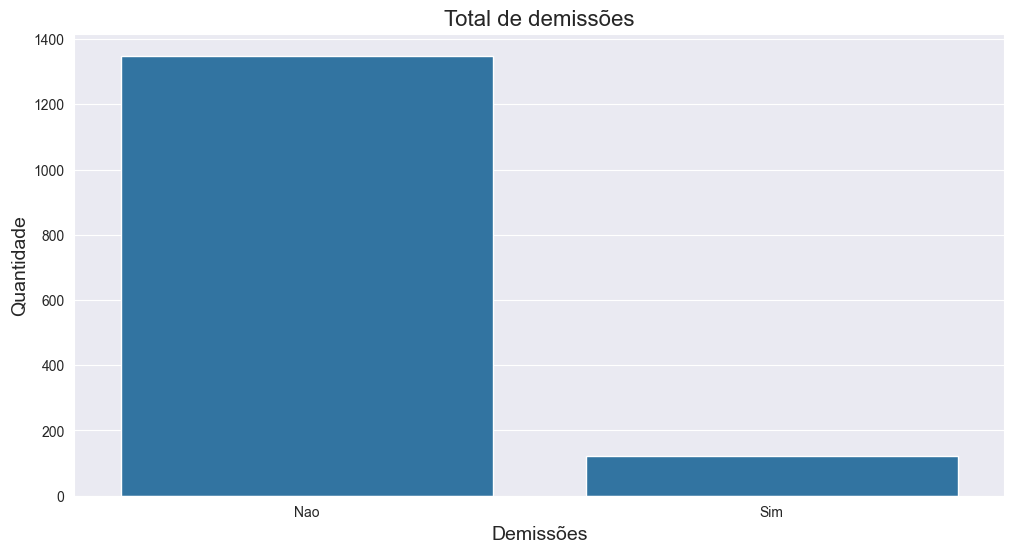

In [31]:
# plots count
ax = sns.countplot(x=df_employee[VARIAVEL_ALVO])

# sets the figure size in inches
ax.figure.set_size_inches(12, 6)

# set plot features
ax.set_title("Total de demissões", fontsize=16)
ax.set_ylabel("Quantidade", fontsize=14)
ax.set_xlabel("Demissões", fontsize=14)

# displays plot
plt.show()

Como observado, há muito mais pessoas que permaneceram na empresa do que as que saíram.

In [32]:
# separating the data set for easier analysis
df_left = df_employee[df_employee[VARIAVEL_ALVO] == 'Sim']
df_stayed = df_employee[df_employee[VARIAVEL_ALVO] == 'Nao']

In [33]:
# Count the number of employees who stayed and left
# It seems that we are dealing with an imbalanced dataset
total_employees_left = df_left.shape[0]
total_employees_stayed = df_stayed.shape[0]
total_employees = df_employee.shape[0]

print('Número de funcionários que saíram:', total_employees_left)
print('Isso é equivalente a {:.2f}% do total de funcionários'.format((total_employees_left/total_employees)*100))

print('\nNúmero de funcionários que permaneceram:', total_employees_stayed)
print('Isso é equivalente a {:.2f}% do total de funcionários'.format((total_employees_stayed/total_employees)*100))

Número de funcionários que saíram: 121
Isso é equivalente a 8.23% do total de funcionários

Número de funcionários que permaneceram: 1349
Isso é equivalente a 91.77% do total de funcionários


### 7.3.2 Variáveis numéricas

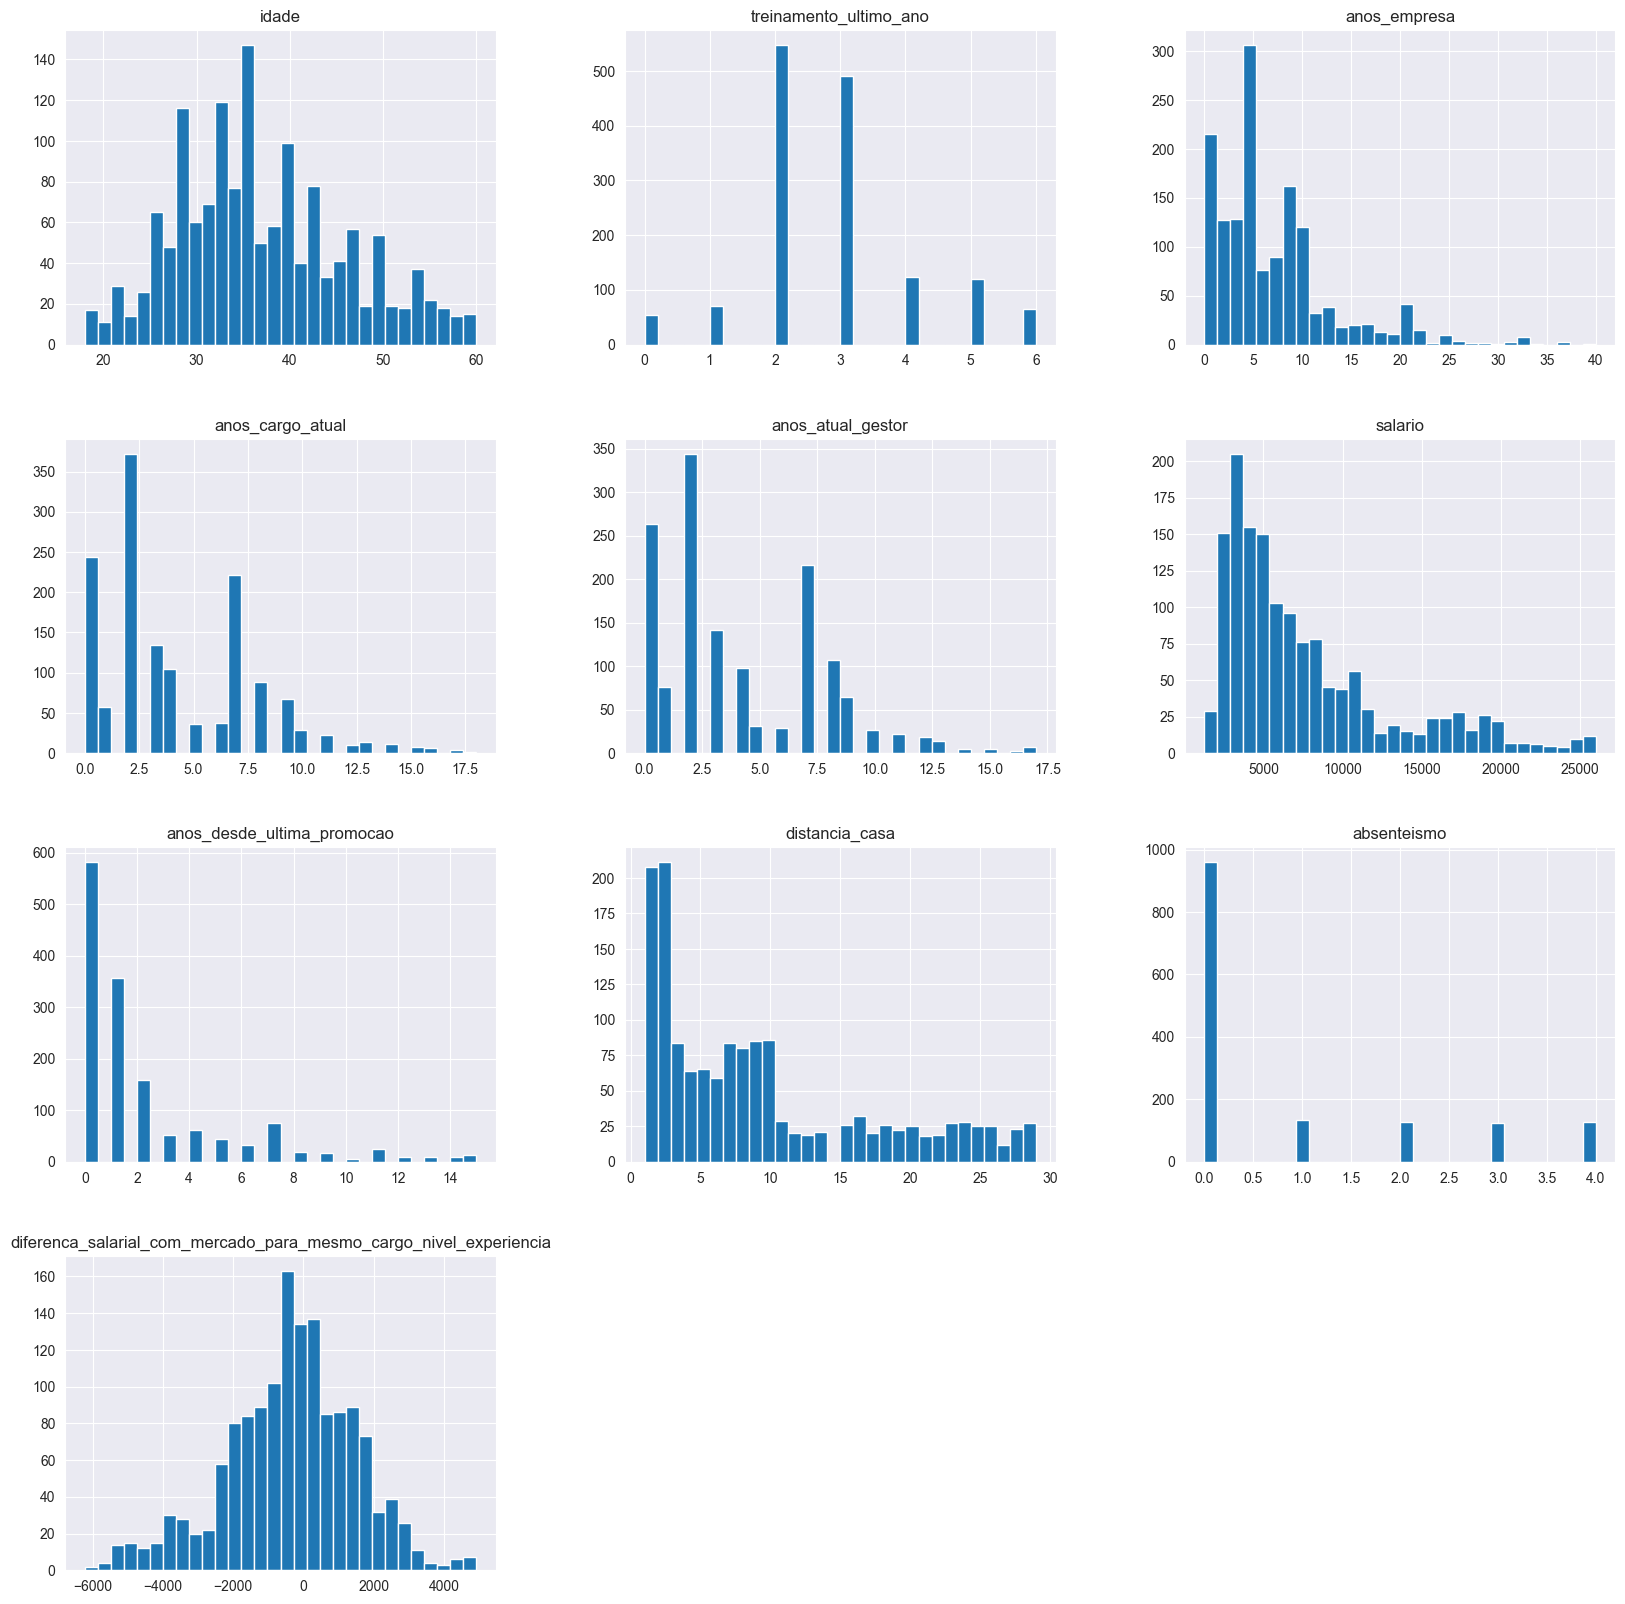

In [34]:
# plots a histogram for all numerical attributes
_ = num_attributes.hist(bins=30, figsize=(20,20))

### 7.3.3 Variáveis categóricas

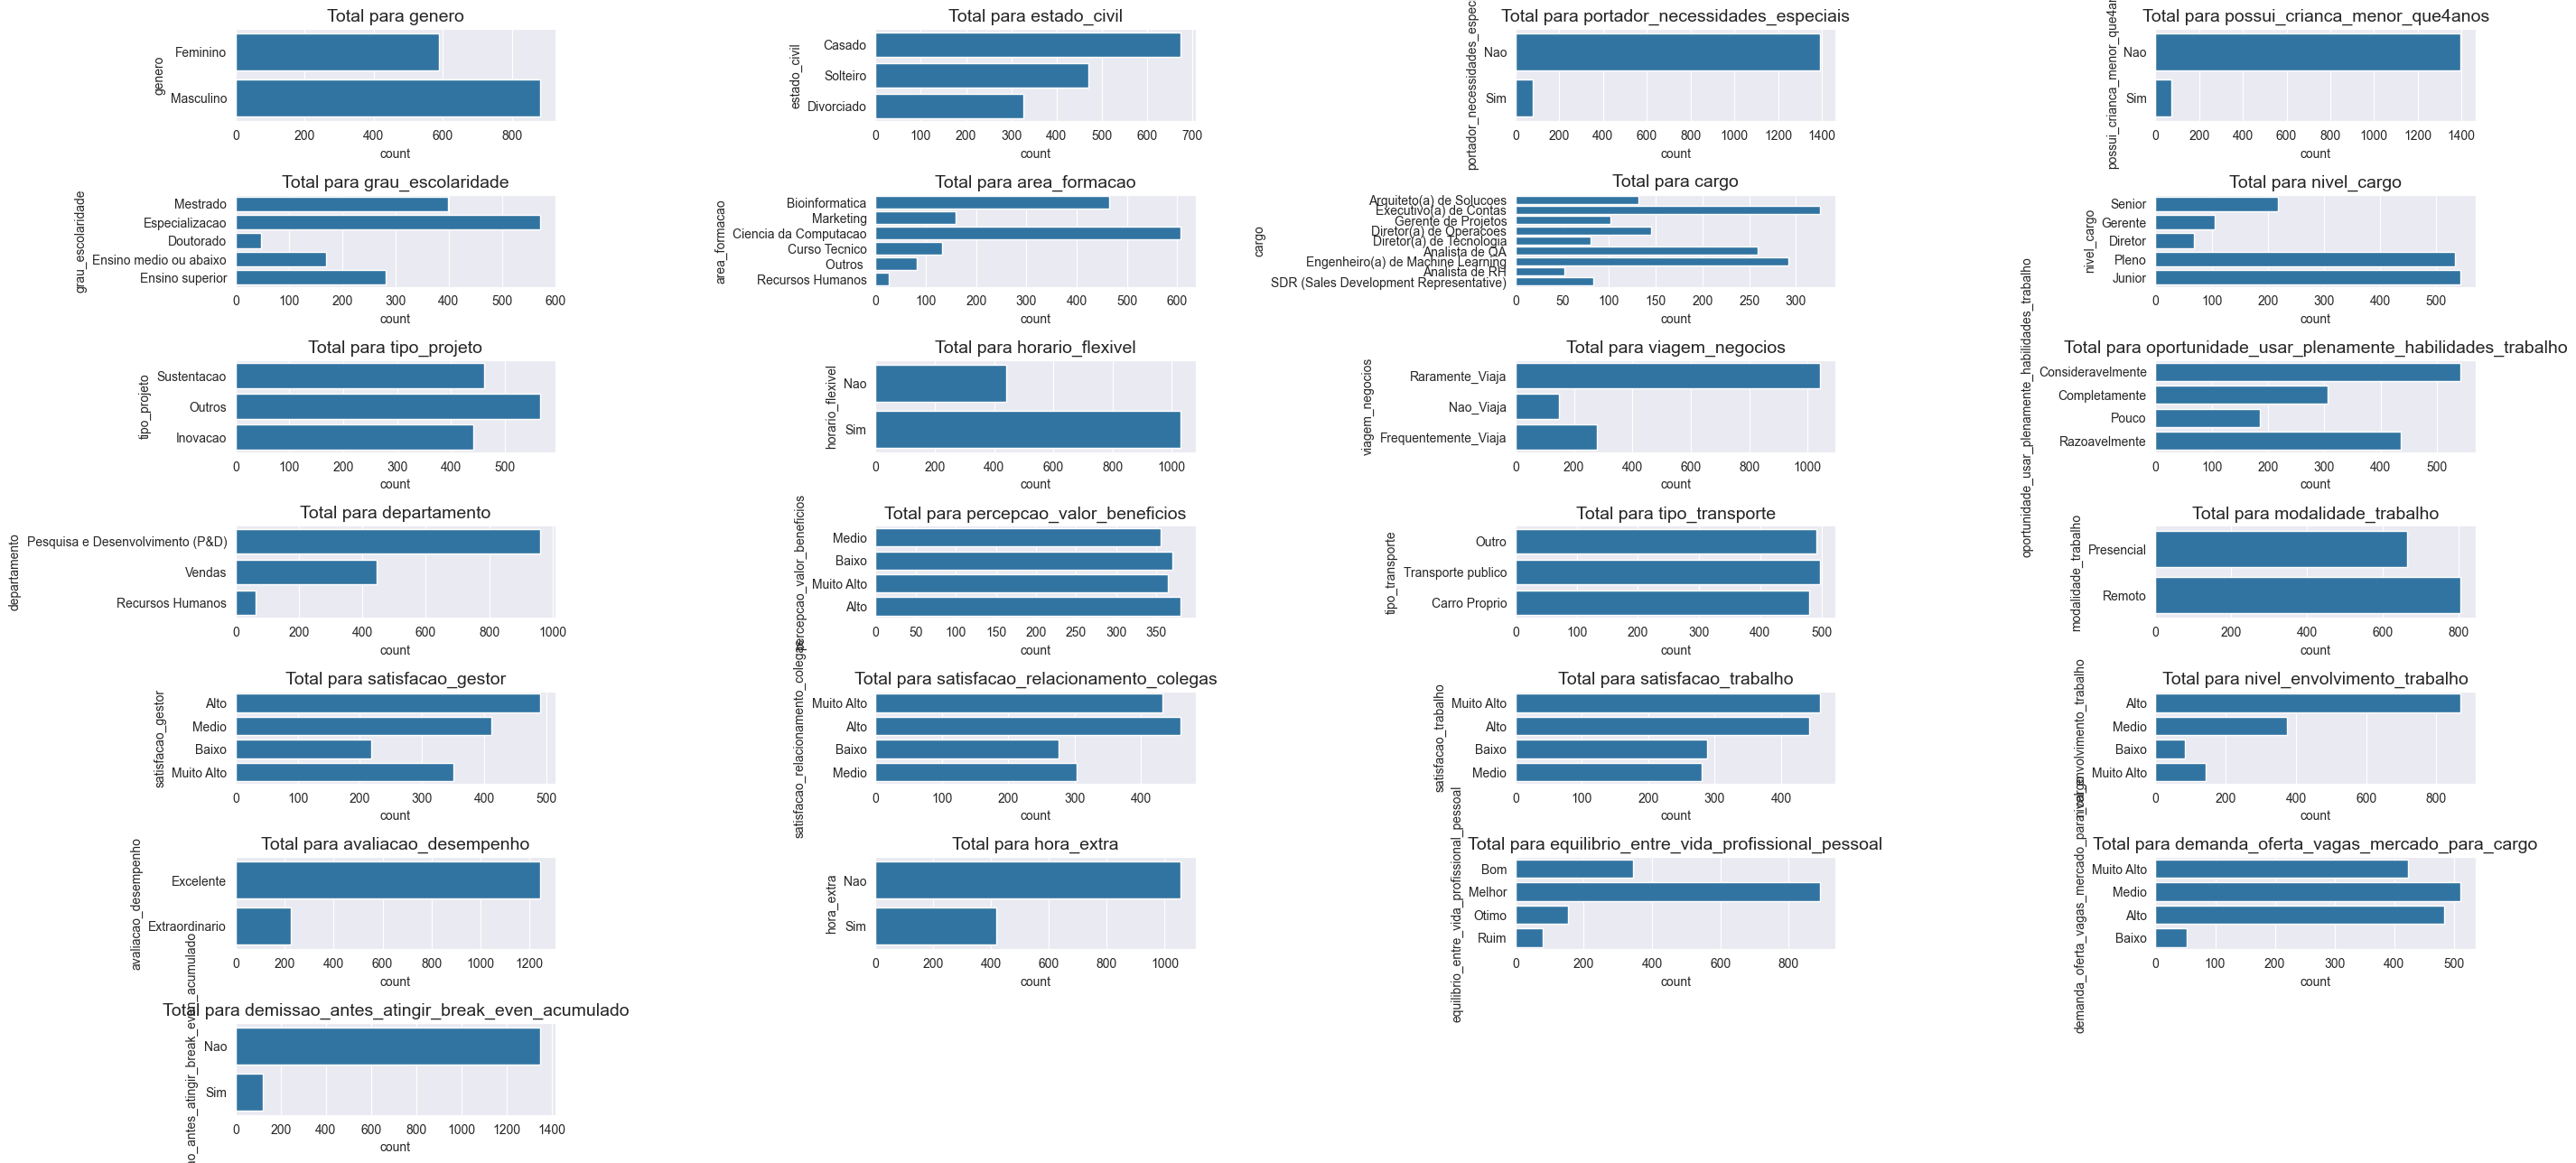

In [35]:
# sets plot size
plt.figure(figsize=(32, 18))

# sets the inital plot position
n = 1

# iterates over the columns to plot
for column in cat_attributes.columns:
    if column == "id":
        continue
    plt.subplot(8, 4, n)
    _ = sns.countplot(y=cat_attributes[column])
    plt.title("Total para " + column, fontsize=14)
    n += 1

# adjust height and wdith reserved for space between subplots
plt.subplots_adjust(hspace=0.8)
plt.subplots_adjust(wspace=1.0)

# display the plot
plt.show()

## 7.4 Análise bivariada - validação de hipóteses

### H1. Funcionários vinculados a modalidade de trabalho presencial possuem maior tendência de pedir demissão. <font color="green">VERDADEIRO</font>

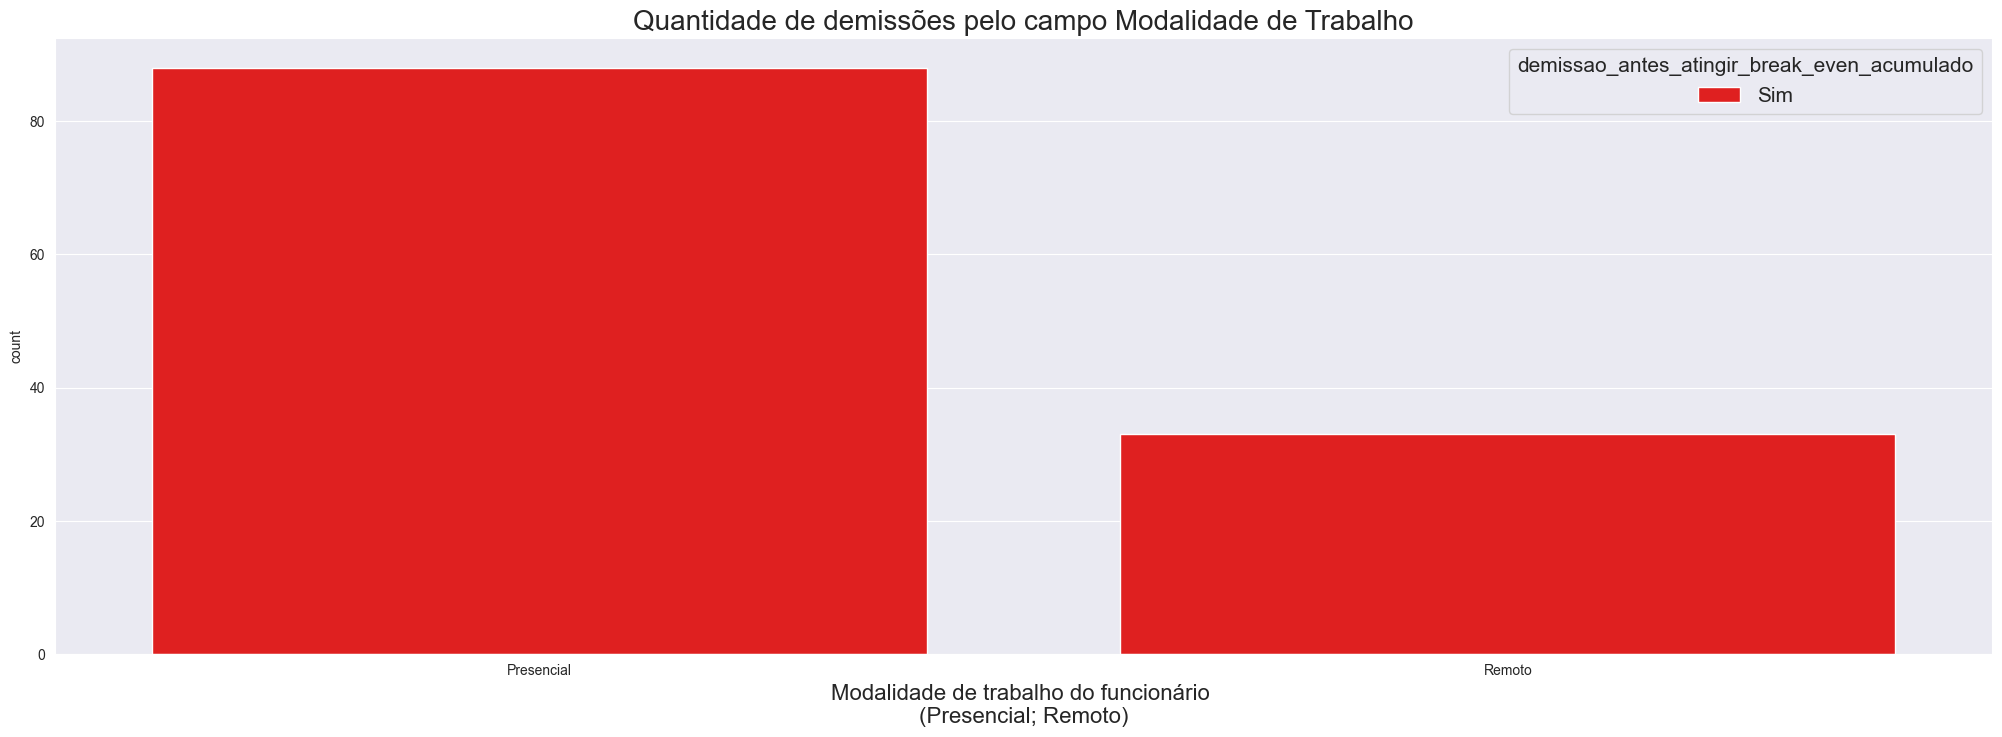

In [36]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='modalidade_trabalho', hue=VARIAVEL_ALVO, data=df_left, palette=['r'])

# sets plot title
ax.set_title("Quantidade de demissões pelo campo Modalidade de Trabalho", fontsize=20)

# sets xlabel
plt.xlabel('Modalidade de trabalho do funcionário \n(Presencial; Remoto)', fontsize=16)

# sets the legend
plt.legend(title=VARIAVEL_ALVO, title_fontsize=15, fontsize=15)

# display plots
plt.show()

### H2. Funcionários que estão vinulados a projetos de 'Sustentação' possuem maior tendência de pedir demissão. <font color="green">VERDADEIRO</font>

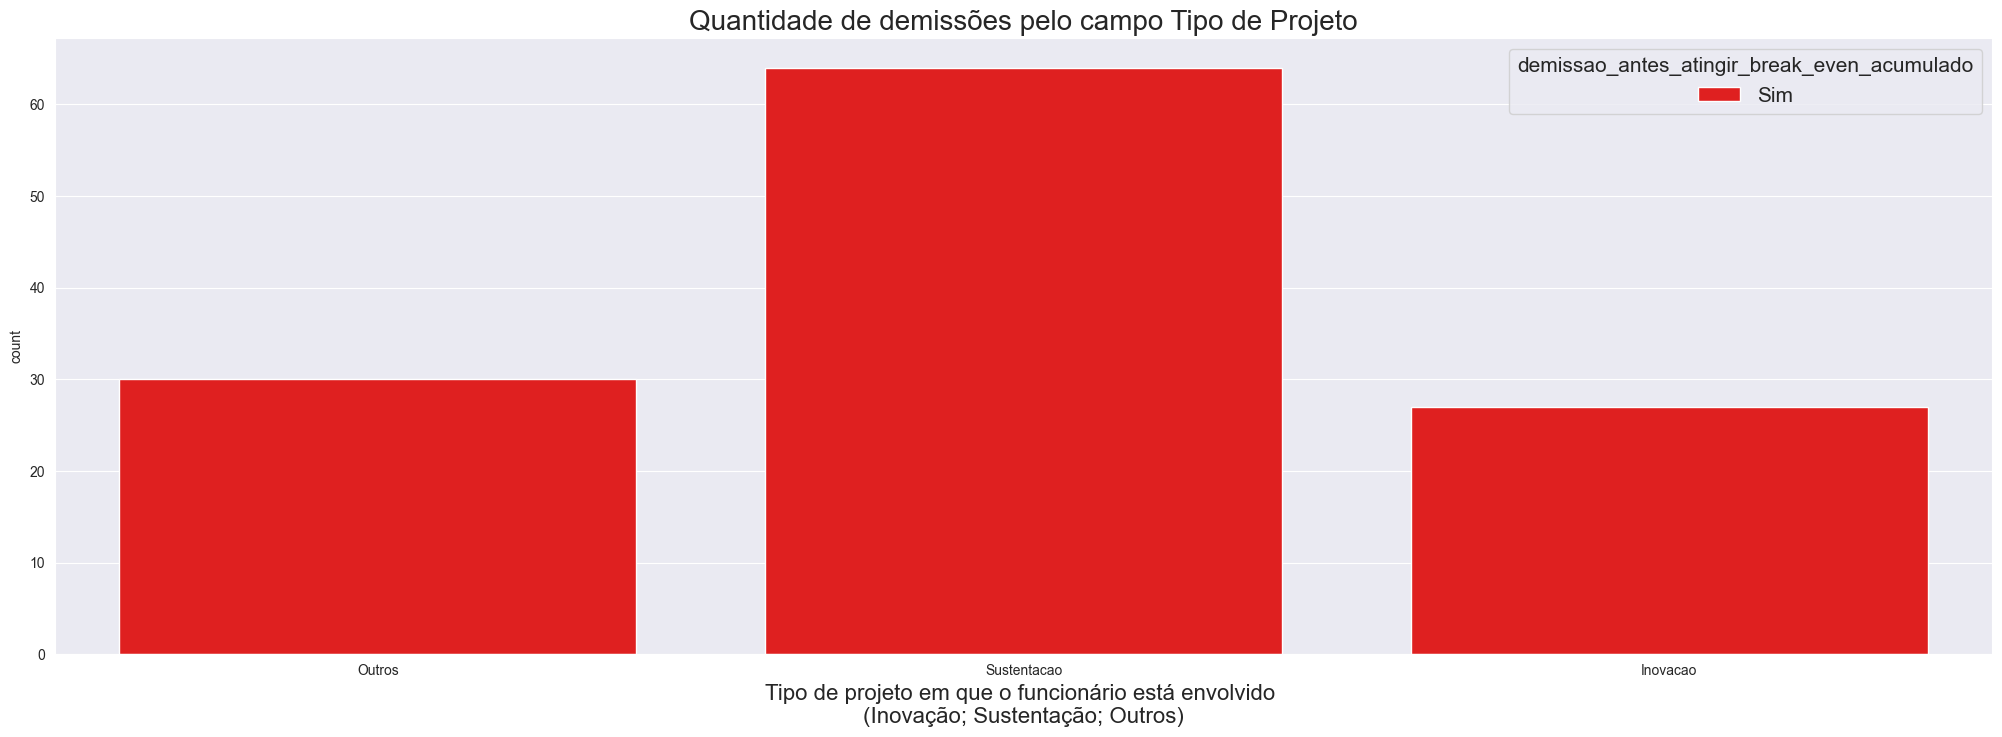

In [37]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='tipo_projeto', hue=VARIAVEL_ALVO, data=df_left, palette=['r'])

# sets plot title
ax.set_title("Quantidade de demissões pelo campo Tipo de Projeto", fontsize=20)

# sets xlabel
plt.xlabel('Tipo de projeto em que o funcionário está envolvido \n(Inovação; Sustentação; Outros)', fontsize=16)

# sets the legend
plt.legend(title=VARIAVEL_ALVO, title_fontsize=15, fontsize=15)

# display plots
plt.show()

### H3. Funcionários que utilizam pouco ou apenas razoavelmente suas habilidades no trabalho possuem maior tendência de pedir demissão. <font color="red">FALSO</font>

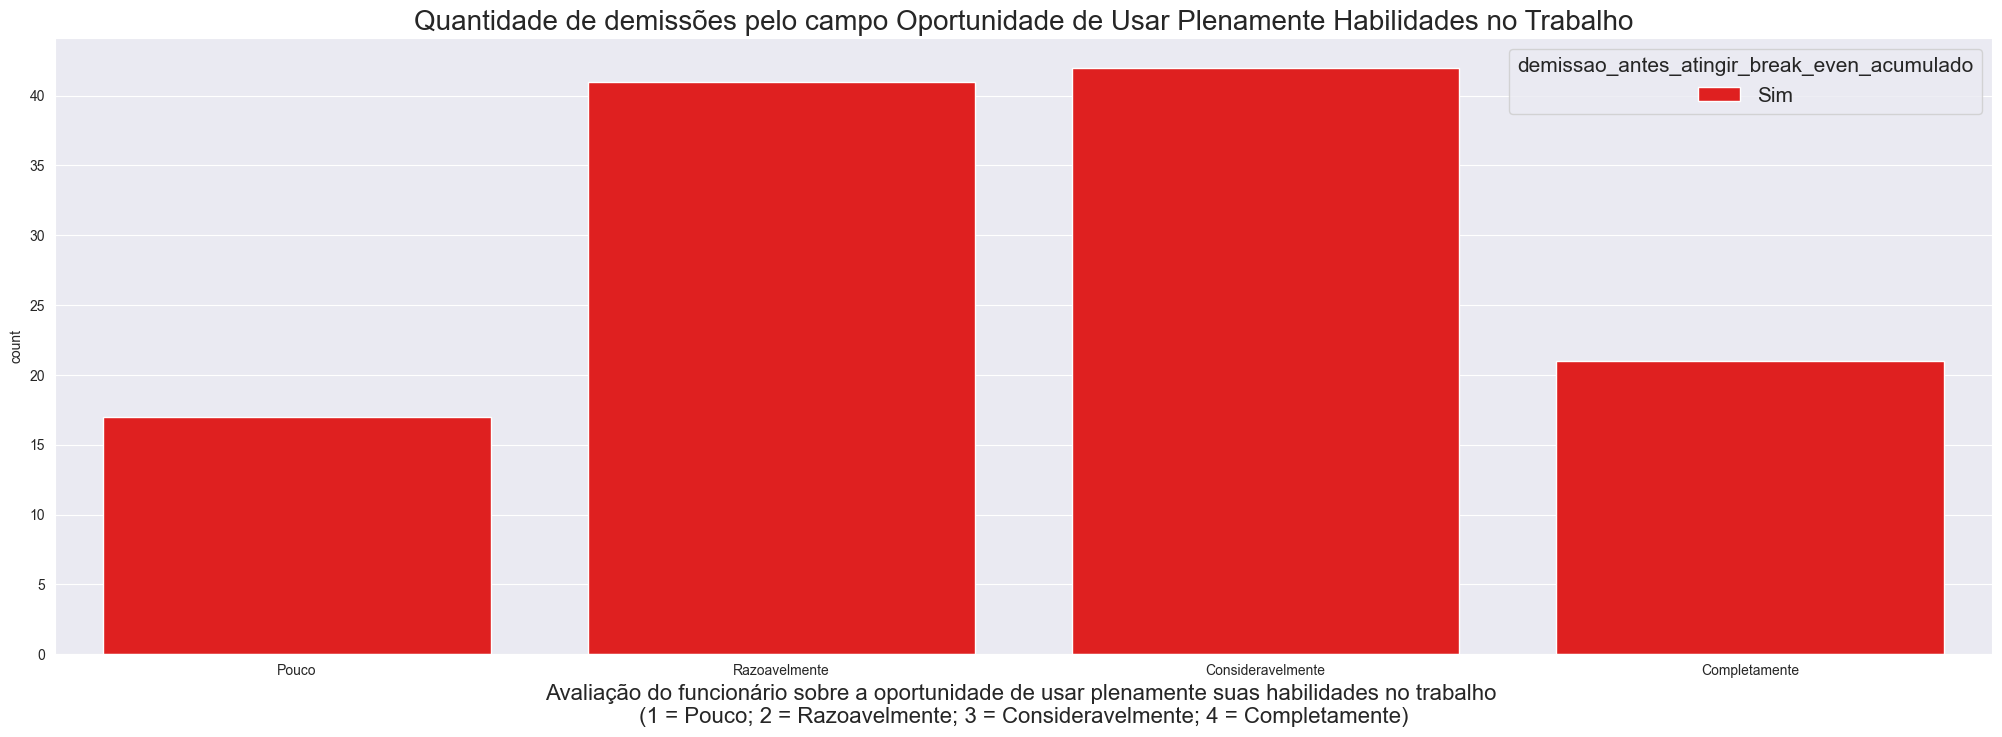

In [38]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# sets the desired order of categories
categories_order = ['Pouco', 'Razoavelmente', 'Consideravelmente', 'Completamente']

# plots the graph
sns.countplot(x='oportunidade_usar_plenamente_habilidades_trabalho', hue=VARIAVEL_ALVO, data=df_left, palette=['r'], order=categories_order)

# sets plot title
ax.set_title("Quantidade de demissões pelo campo Oportunidade de Usar Plenamente Habilidades no Trabalho", fontsize=20)

# sets xlabel
plt.xlabel('Avaliação do funcionário sobre a oportunidade de usar plenamente suas habilidades no trabalho \n(1 = Pouco; 2 = Razoavelmente; 3 = Consideravelmente; 4 = Completamente)', fontsize=16)

# sets the legend
plt.legend(title=VARIAVEL_ALVO, title_fontsize=15, fontsize=15)

# display plots
plt.show()

### H4. Funcionários que estão há três anos ou mais sem promoção possuem maior tendência de pedir demissão. <font color="red">FALSO</font>

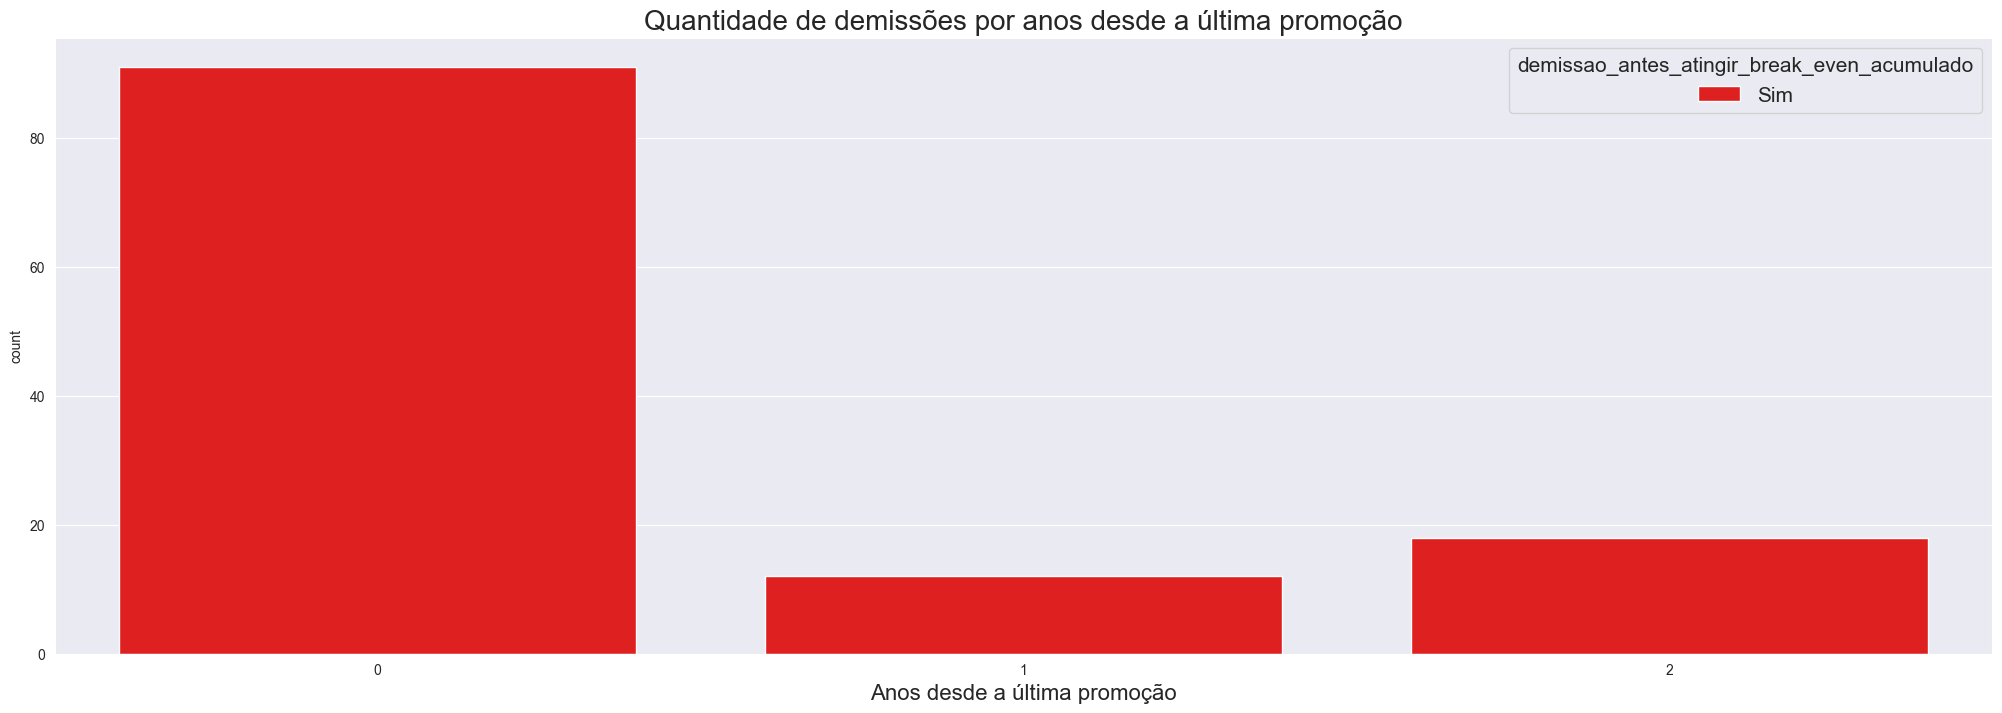

In [39]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='anos_desde_ultima_promocao', hue=VARIAVEL_ALVO, data=df_left, palette=['r'])

# sets plot title
ax.set_title("Quantidade de demissões por anos desde a última promoção", fontsize=20)

# sets xlabel
plt.xlabel('Anos desde a última promoção', fontsize=16)

# sets the legend
plt.legend(title=VARIAVEL_ALVO, title_fontsize=15, fontsize=15)

# display plots
plt.show()



### H5. Funcionários que possuem satisfação com o trabalho baixa possuem maior tendência de pedir demissão. <font color="red">FALSO</font>

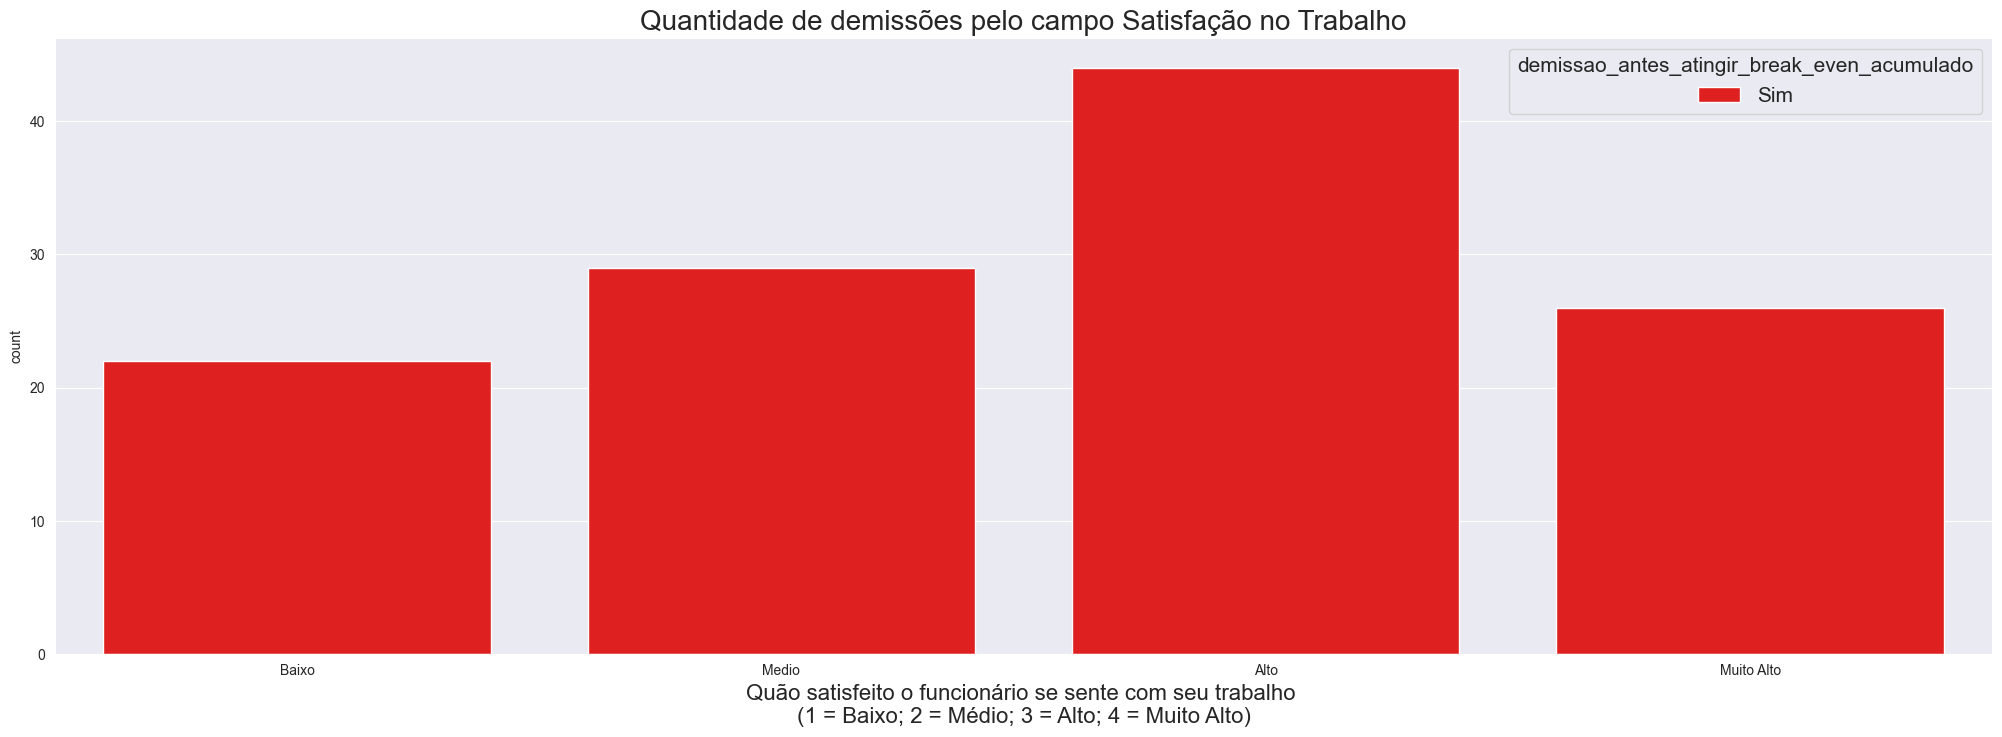

In [40]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# sets the desired order of categories
categories_order = ['Baixo', 'Medio', 'Alto', 'Muito Alto']

# plots the graph
sns.countplot(x='satisfacao_trabalho', hue=VARIAVEL_ALVO, data=df_left, palette=['r'], order=categories_order)

# sets plot title
ax.set_title("Quantidade de demissões pelo campo Satisfação no Trabalho", fontsize=20)

# sets xlabel
plt.xlabel('Quão satisfeito o funcionário se sente com seu trabalho \n(1 = Baixo; 2 = Médio; 3 = Alto; 4 = Muito Alto)', fontsize=16)

# sets the legend
plt.legend(title=VARIAVEL_ALVO, title_fontsize=15, fontsize=15)

# display plots
plt.show()

### H6. Quando a demanda e oferta no mercado de trabalho está alta ou muito alta para o cargo do funcionário, os mesmos possuem maior tendência de pedir demissão. <font color="green">VERDADEIRO</font>

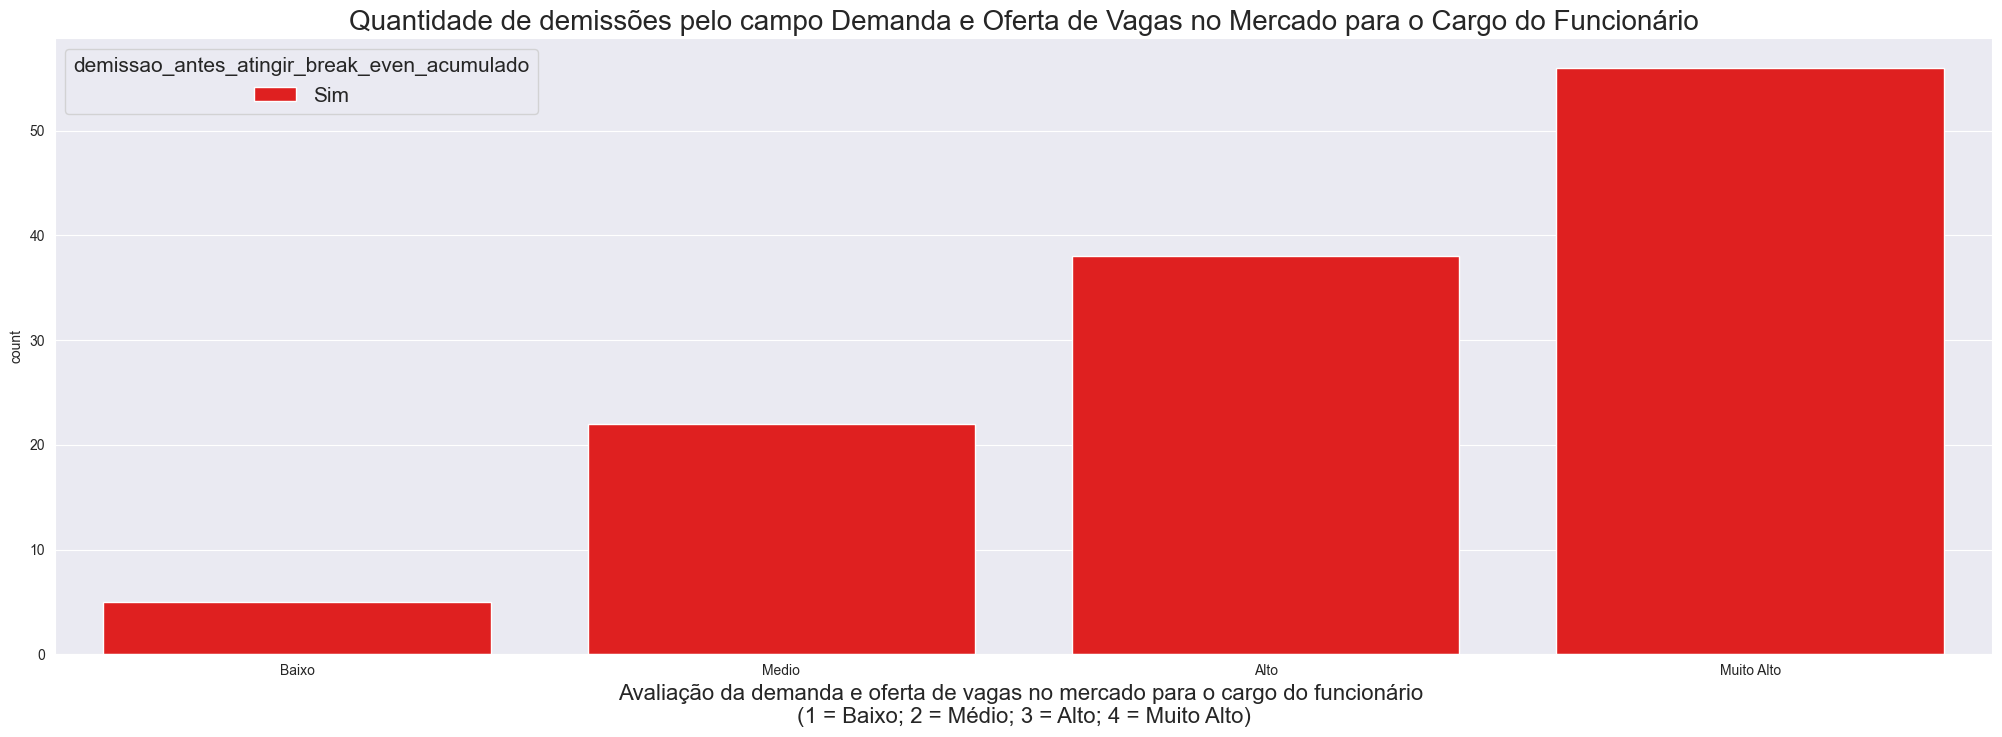

In [41]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# sets the desired order of categories
categories_order = ['Baixo', 'Medio', 'Alto', 'Muito Alto']

# plots the graph
sns.countplot(x='demanda_oferta_vagas_mercado_para_cargo', hue=VARIAVEL_ALVO, data=df_left, palette=['r'], order=categories_order)

# sets plot title
ax.set_title("Quantidade de demissões pelo campo Demanda e Oferta de Vagas no Mercado para o Cargo do Funcionário", fontsize=20)

# sets xlabel
plt.xlabel('Avaliação da demanda e oferta de vagas no mercado para o cargo do funcionário \n(1 = Baixo; 2 = Médio; 3 = Alto; 4 = Muito Alto)', fontsize=16)

# sets the legend
plt.legend(title=VARIAVEL_ALVO, title_fontsize=15, fontsize=15)

# display plots
plt.show()

### H7. Quando o salário de mercado for maior que o recebido atualmente pelo funcionário, o mesmos possui maior tendência de pedir demissão. <font color="green">VERDADEIRO</font>

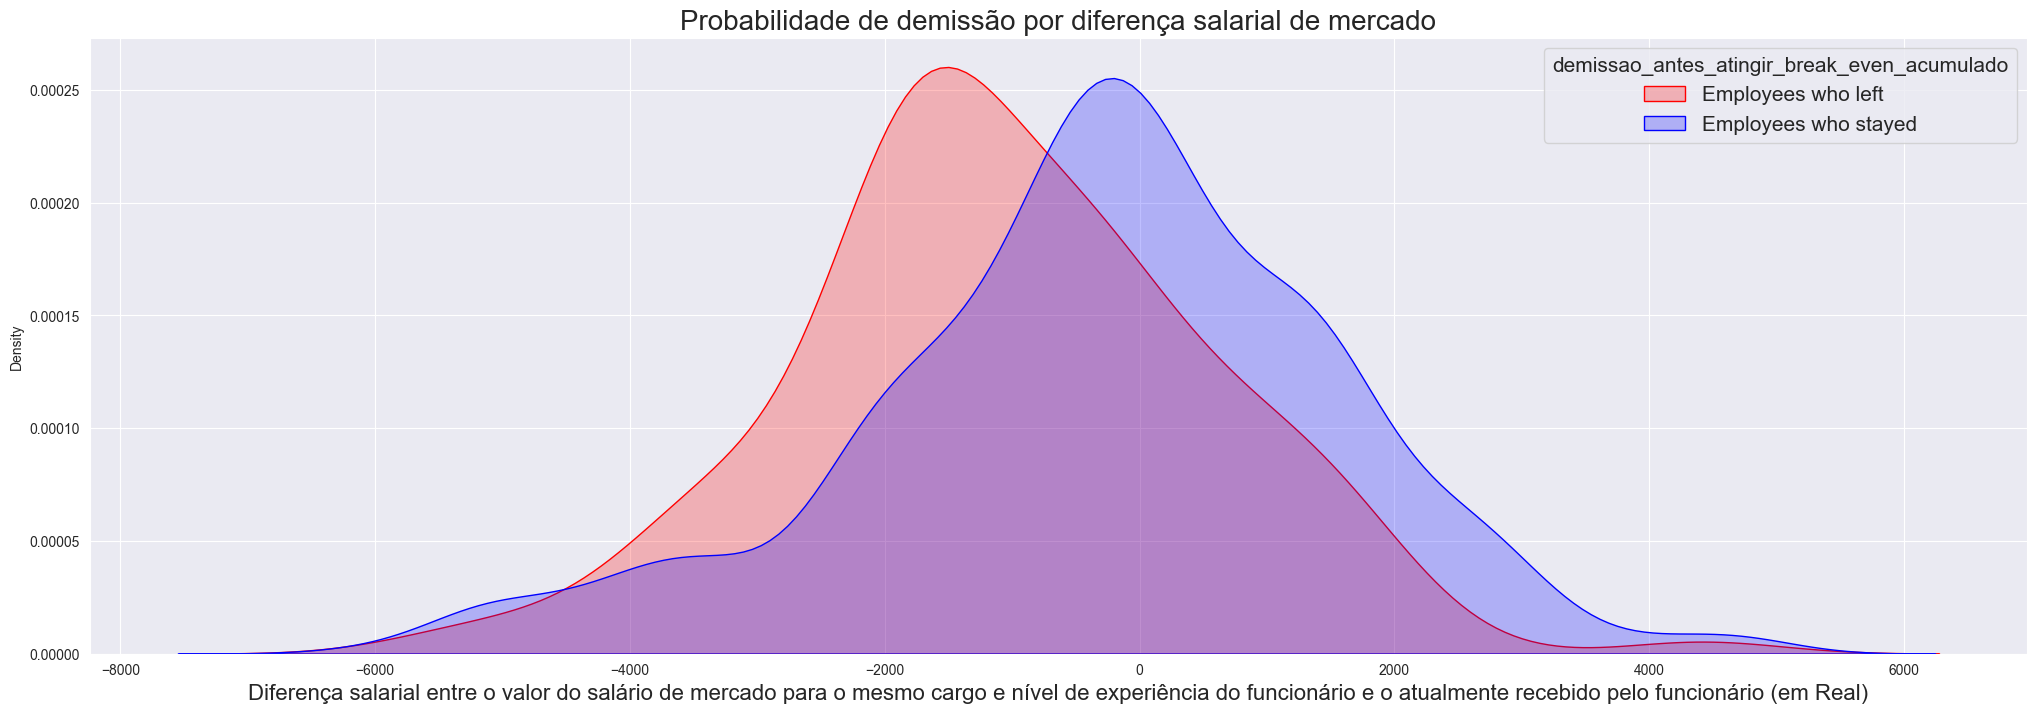

In [42]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# KDE (Kernel Density Estimate) is used for visualizing the Probability Density of continuos variable.
# KDE describes the probability density at different values in a continuous variable
sns.kdeplot(df_left['diferenca_salarial_com_mercado_para_mesmo_cargo_nivel_experiencia'], label='Employees who left', fill=True, color='r')
sns.kdeplot(df_stayed['diferenca_salarial_com_mercado_para_mesmo_cargo_nivel_experiencia'], label='Employees who stayed', fill=True, color='b')

# sets plot title
ax.set_title("Probabilidade de demissão por diferença salarial de mercado", fontsize=20)

# sets x label
plt.xlabel('Diferença salarial entre o valor do salário de mercado para o mesmo cargo e nível de experiência do funcionário e o atualmente recebido pelo funcionário (em Real)', fontsize=16)

# sets the legend
plt.legend(title=VARIAVEL_ALVO, title_fontsize=15, fontsize=15)

# displays the plot
plt.show()

### H8. Funcionários que possuem percepção de valor baixo dos benefícios recebidos pela empresa (Vale alimentação, Plano de Saúde, Vale academia, dentre outros) possuem maior tendência de pedir demissão. <font color="red">FALSO</font>

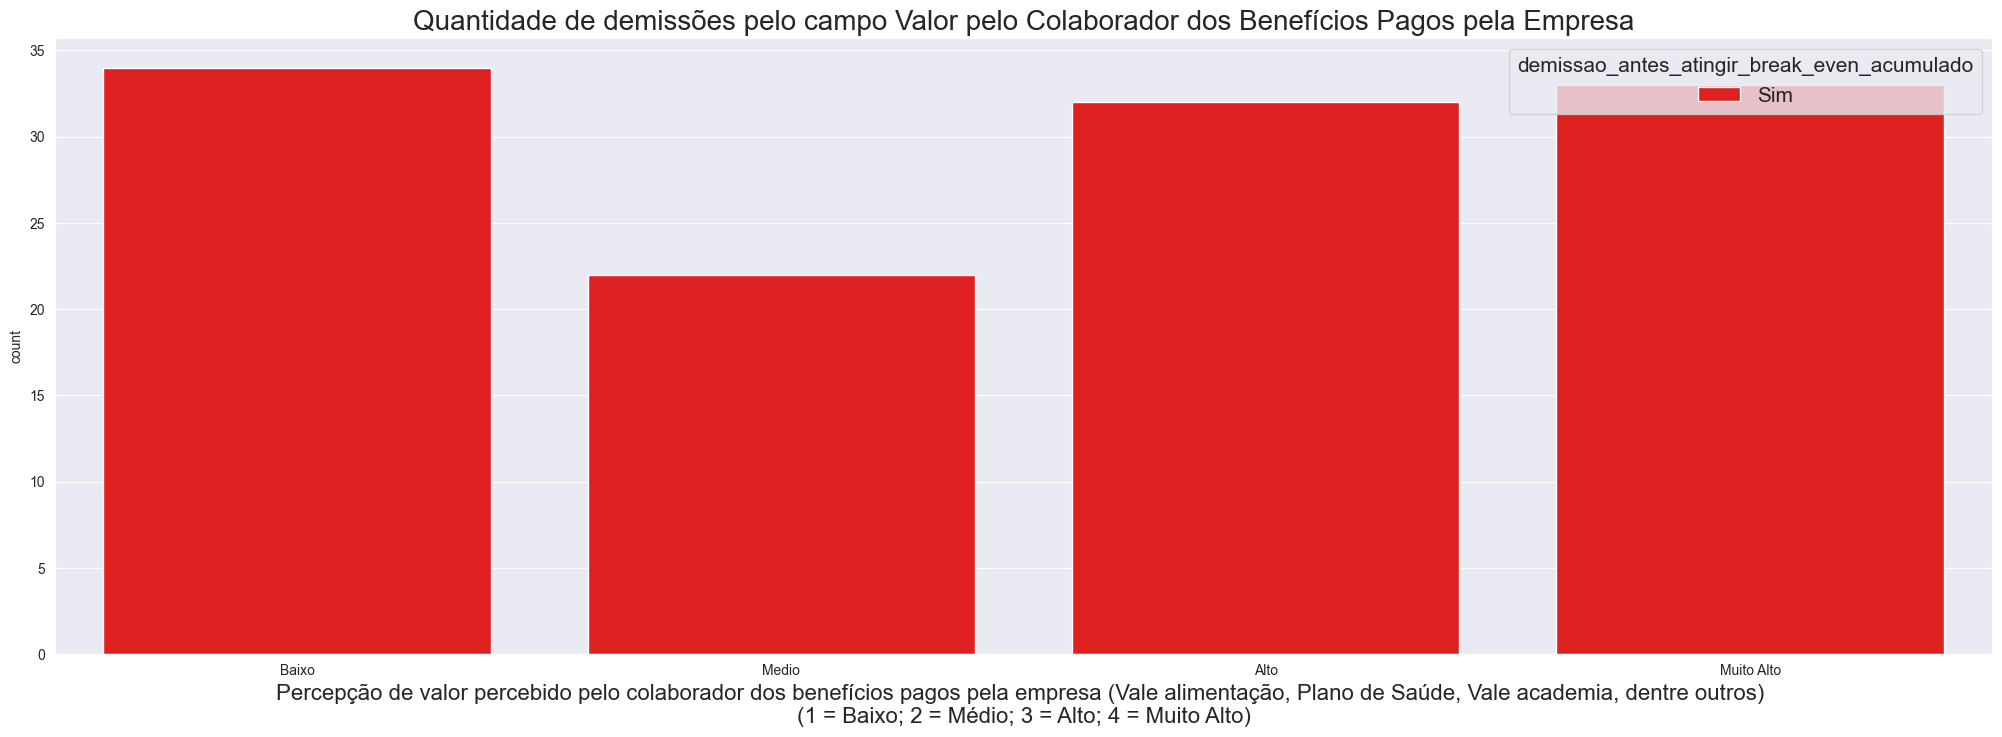

In [43]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# sets the desired order of categories
categories_order = ['Baixo', 'Medio', 'Alto', 'Muito Alto']

# plots the graph
sns.countplot(x='percepcao_valor_beneficios', hue=VARIAVEL_ALVO, data=df_left, palette=['r'], order=categories_order)

# sets plot title
ax.set_title("Quantidade de demissões pelo campo Valor pelo Colaborador dos Benefícios Pagos pela Empresa", fontsize=20)

# sets xlabel
plt.xlabel('Percepção de valor percebido pelo colaborador dos benefícios pagos pela empresa (Vale alimentação, Plano de Saúde, Vale academia, dentre outros) \n(1 = Baixo; 2 = Médio; 3 = Alto; 4 = Muito Alto)', fontsize=16)

# sets the legend
plt.legend(title=VARIAVEL_ALVO, title_fontsize=15, fontsize=15)

# display plots
plt.show()

### 7.4.1 Hypotheses Summary

| ID | Hipóteses                                                                                                                                                                                          | Conclusão  |
|----|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------|
| H1 | Funcionários vinculados a modalidade de trabalho presencial possuem maior tendência de pedir demissão                                                                                              | VERDADEIRO |
| H2 | Funcionários que estão vinculados a projetos de 'Sustentação' possuem maior tendência de pedir demissão                                                                                            | VERDADEIRO |
| H3 | Funcionários que utilizam pouco ou apenas razoavelmente suas habilidades no trabalho possuem maior tendência de pedir demissão                                                                     | FALSO      |
| H4 | Funcionários que estão há três anos ou mais sem promoção possuem maior tendência de pedir demissão                                                                                                 | FALSO      |
| H5 | Funcionários que possuem satisfação baixa possuem maior tendência de pedir demissão                                                                                                                | FALSO      |
| H6 | Quando a demanda e oferta no mercado de trabalho está alta ou muito alta para o cargo do funcionário, os mesmos possuem maior tendência de pedir demissão                                          | VERDADEIRO |
| H7 | Quando o salário de mercado for maior que o recebido atualmente pelo funcionário, o mesmos possui maior tendência de pedir demissão                                                                | VERDADEIRO |
| H8 | Funcionários que possuem percepção de valor baixo dos benefícios recebidos pela empresa (Vale alimentação, Plano de Saúde, Vale academia, dentre outros) possuem maior tendência de pedir demissão | FALSO      |

## 7.5 Análise multivariada - correlações

### 7.5.1 Correlação entre atributos numéricos (variáveis explicativas)

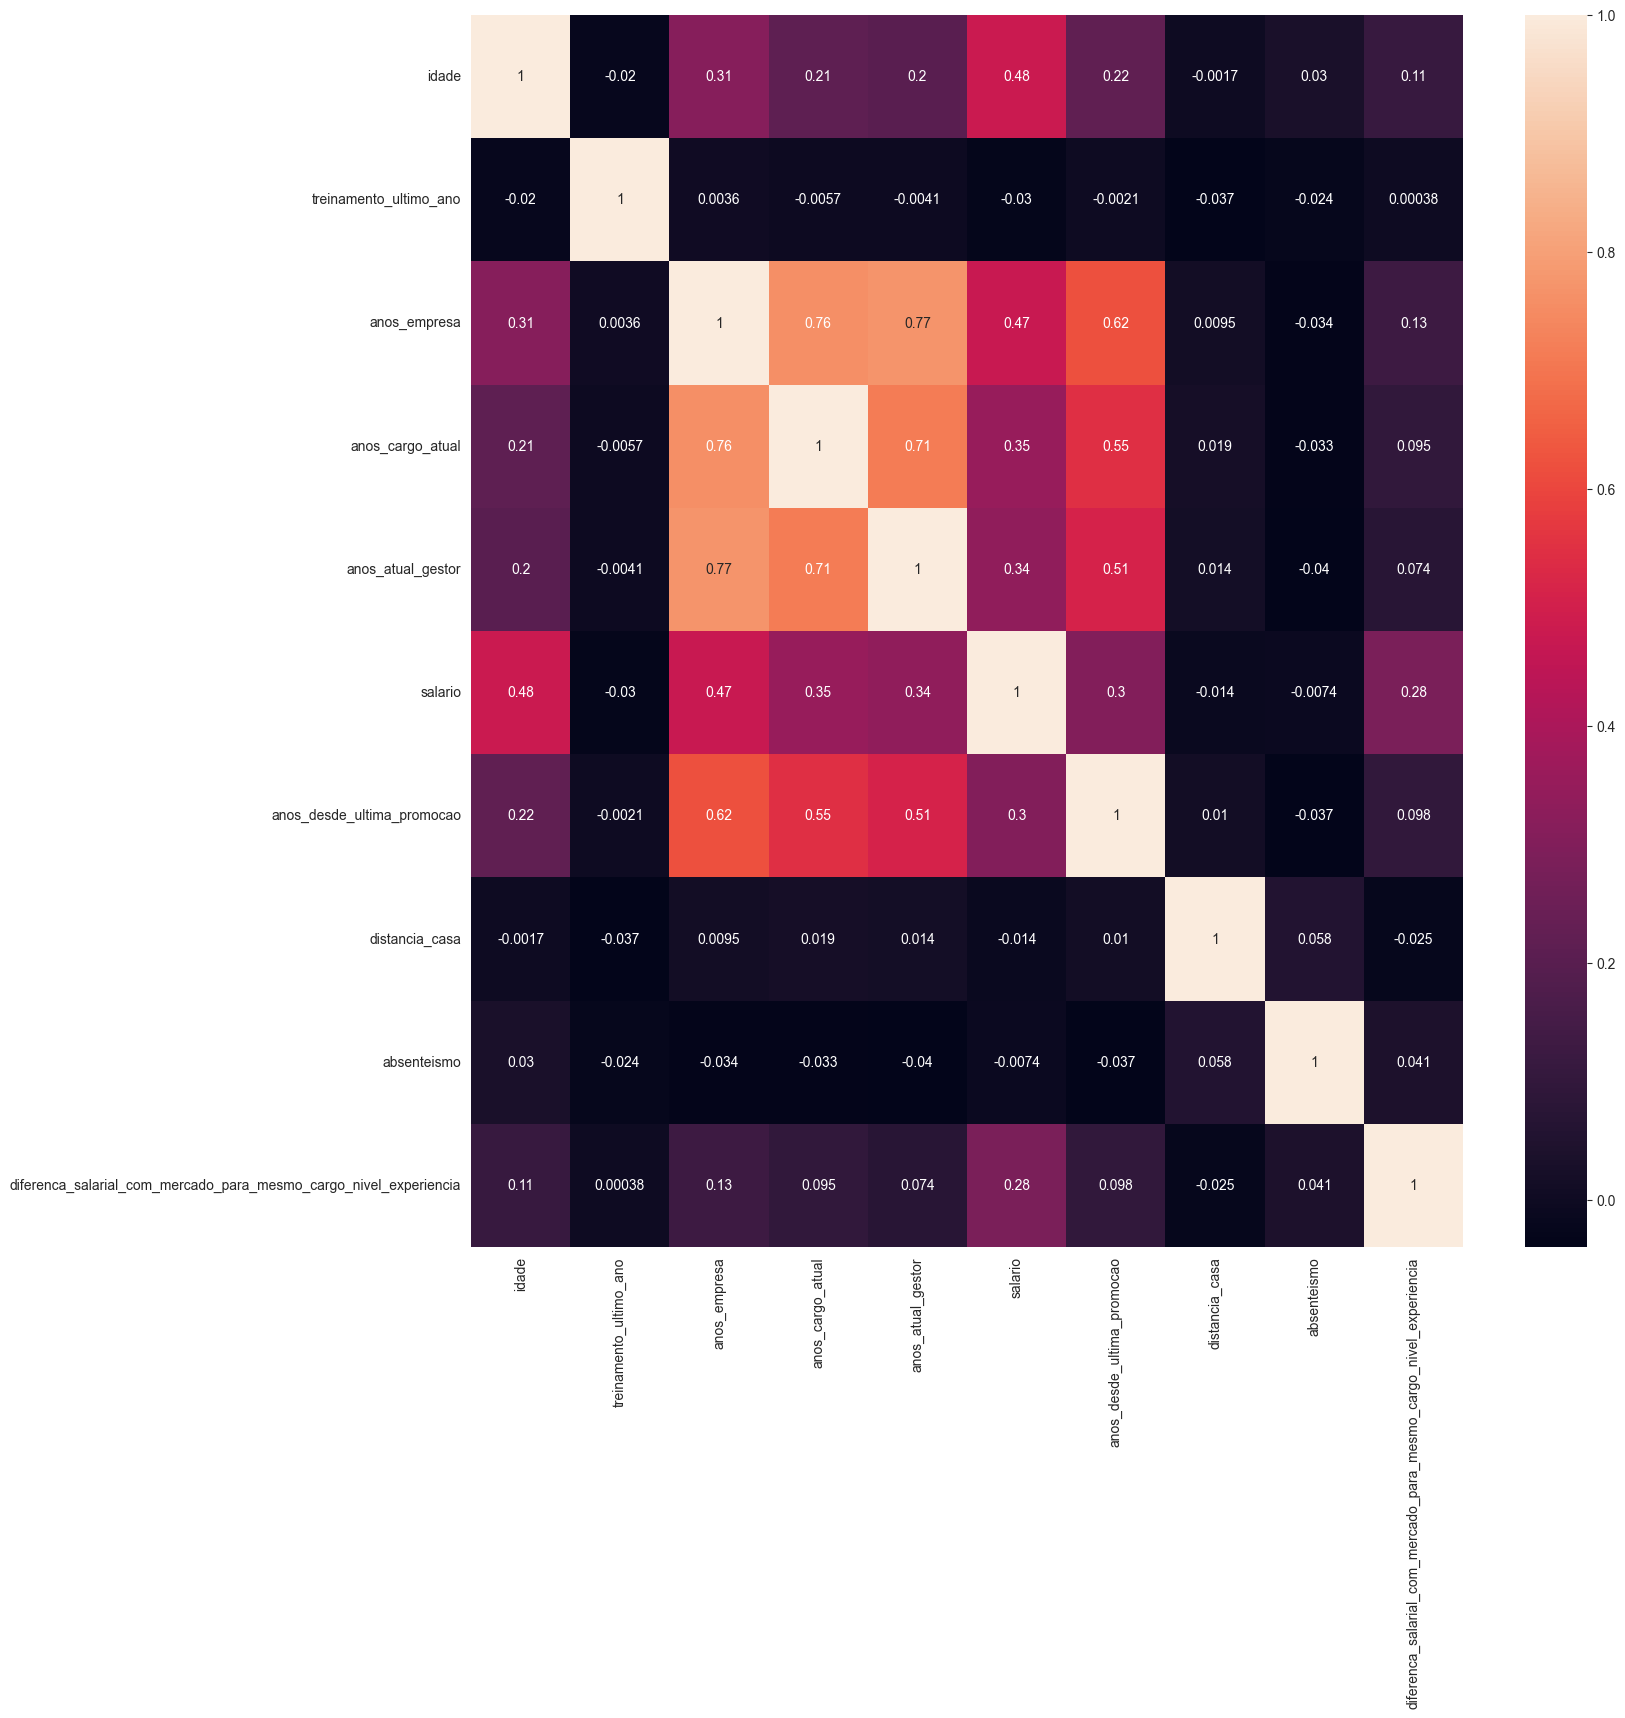

In [44]:
# gets the correlation between the numerical variables
correlation = num_attributes.corr(method='pearson')

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 16)

# plots the heatmap
sns.heatmap(correlation, annot=True)

# displays the plot
plt.show()


### 7.5.2 Correlações entre atributos categóricos (variáveis ​​explicativas)

In [45]:
cat_attributes.head()

,id,genero,estado_civil,portador_necessidades_especiais,possui_crianca_menor_que4anos,grau_escolaridade,area_formacao,cargo,nivel_cargo,tipo_projeto,...,modalidade_trabalho,satisfacao_gestor,satisfacao_relacionamento_colegas,satisfacao_trabalho,nivel_envolvimento_trabalho,avaliacao_desempenho,hora_extra,equilibrio_entre_vida_profissional_pessoal,demanda_oferta_vagas_mercado_para_cargo,demissao_antes_atingir_break_even_acumulado
0,5732dce5-1182-4ee6-80d9-eff46088a7ea,Feminino,Casado,Nao,Nao,Mestrado,Bioinformatica,Arquiteto(a) de Solucoes,Senior,Sustentacao,...,Presencial,Alto,Muito Alto,Muito Alto,Alto,Excelente,Nao,Bom,Muito Alto,Nao
1,d3701f4f-c71f-45e5-9b28-18ee9e94e8e7,Masculino,Solteiro,Nao,Nao,Mestrado,Bioinformatica,Executivo(a) de Contas,Gerente,Outros,...,Presencial,Medio,Alto,Alto,Alto,Excelente,Nao,Bom,Medio,Nao
2,bcc4fbf8-ffb1-4a73-9092-62ab112c0e8e,Masculino,Solteiro,Nao,Nao,Especializacao,Bioinformatica,Gerente de Projetos,Diretor,Sustentacao,...,Remoto,Medio,Alto,Baixo,Alto,Excelente,Sim,Melhor,Medio,Nao
3,25a67e8a-a13f-4531-874a-ab88b614ad77,Masculino,Casado,Nao,Nao,Doutorado,Marketing,Gerente de Projetos,Diretor,Sustentacao,...,Remoto,Alto,Alto,Muito Alto,Medio,Extraordinario,Nao,Melhor,Medio,Nao
4,5b04682d-083b-413b-b02b-0d01d35a24ee,Masculino,Casado,Nao,Nao,Mestrado,Marketing,Gerente de Projetos,Gerente,Sustentacao,...,Remoto,Baixo,Baixo,Baixo,Medio,Excelente,Nao,Otimo,Medio,Nao


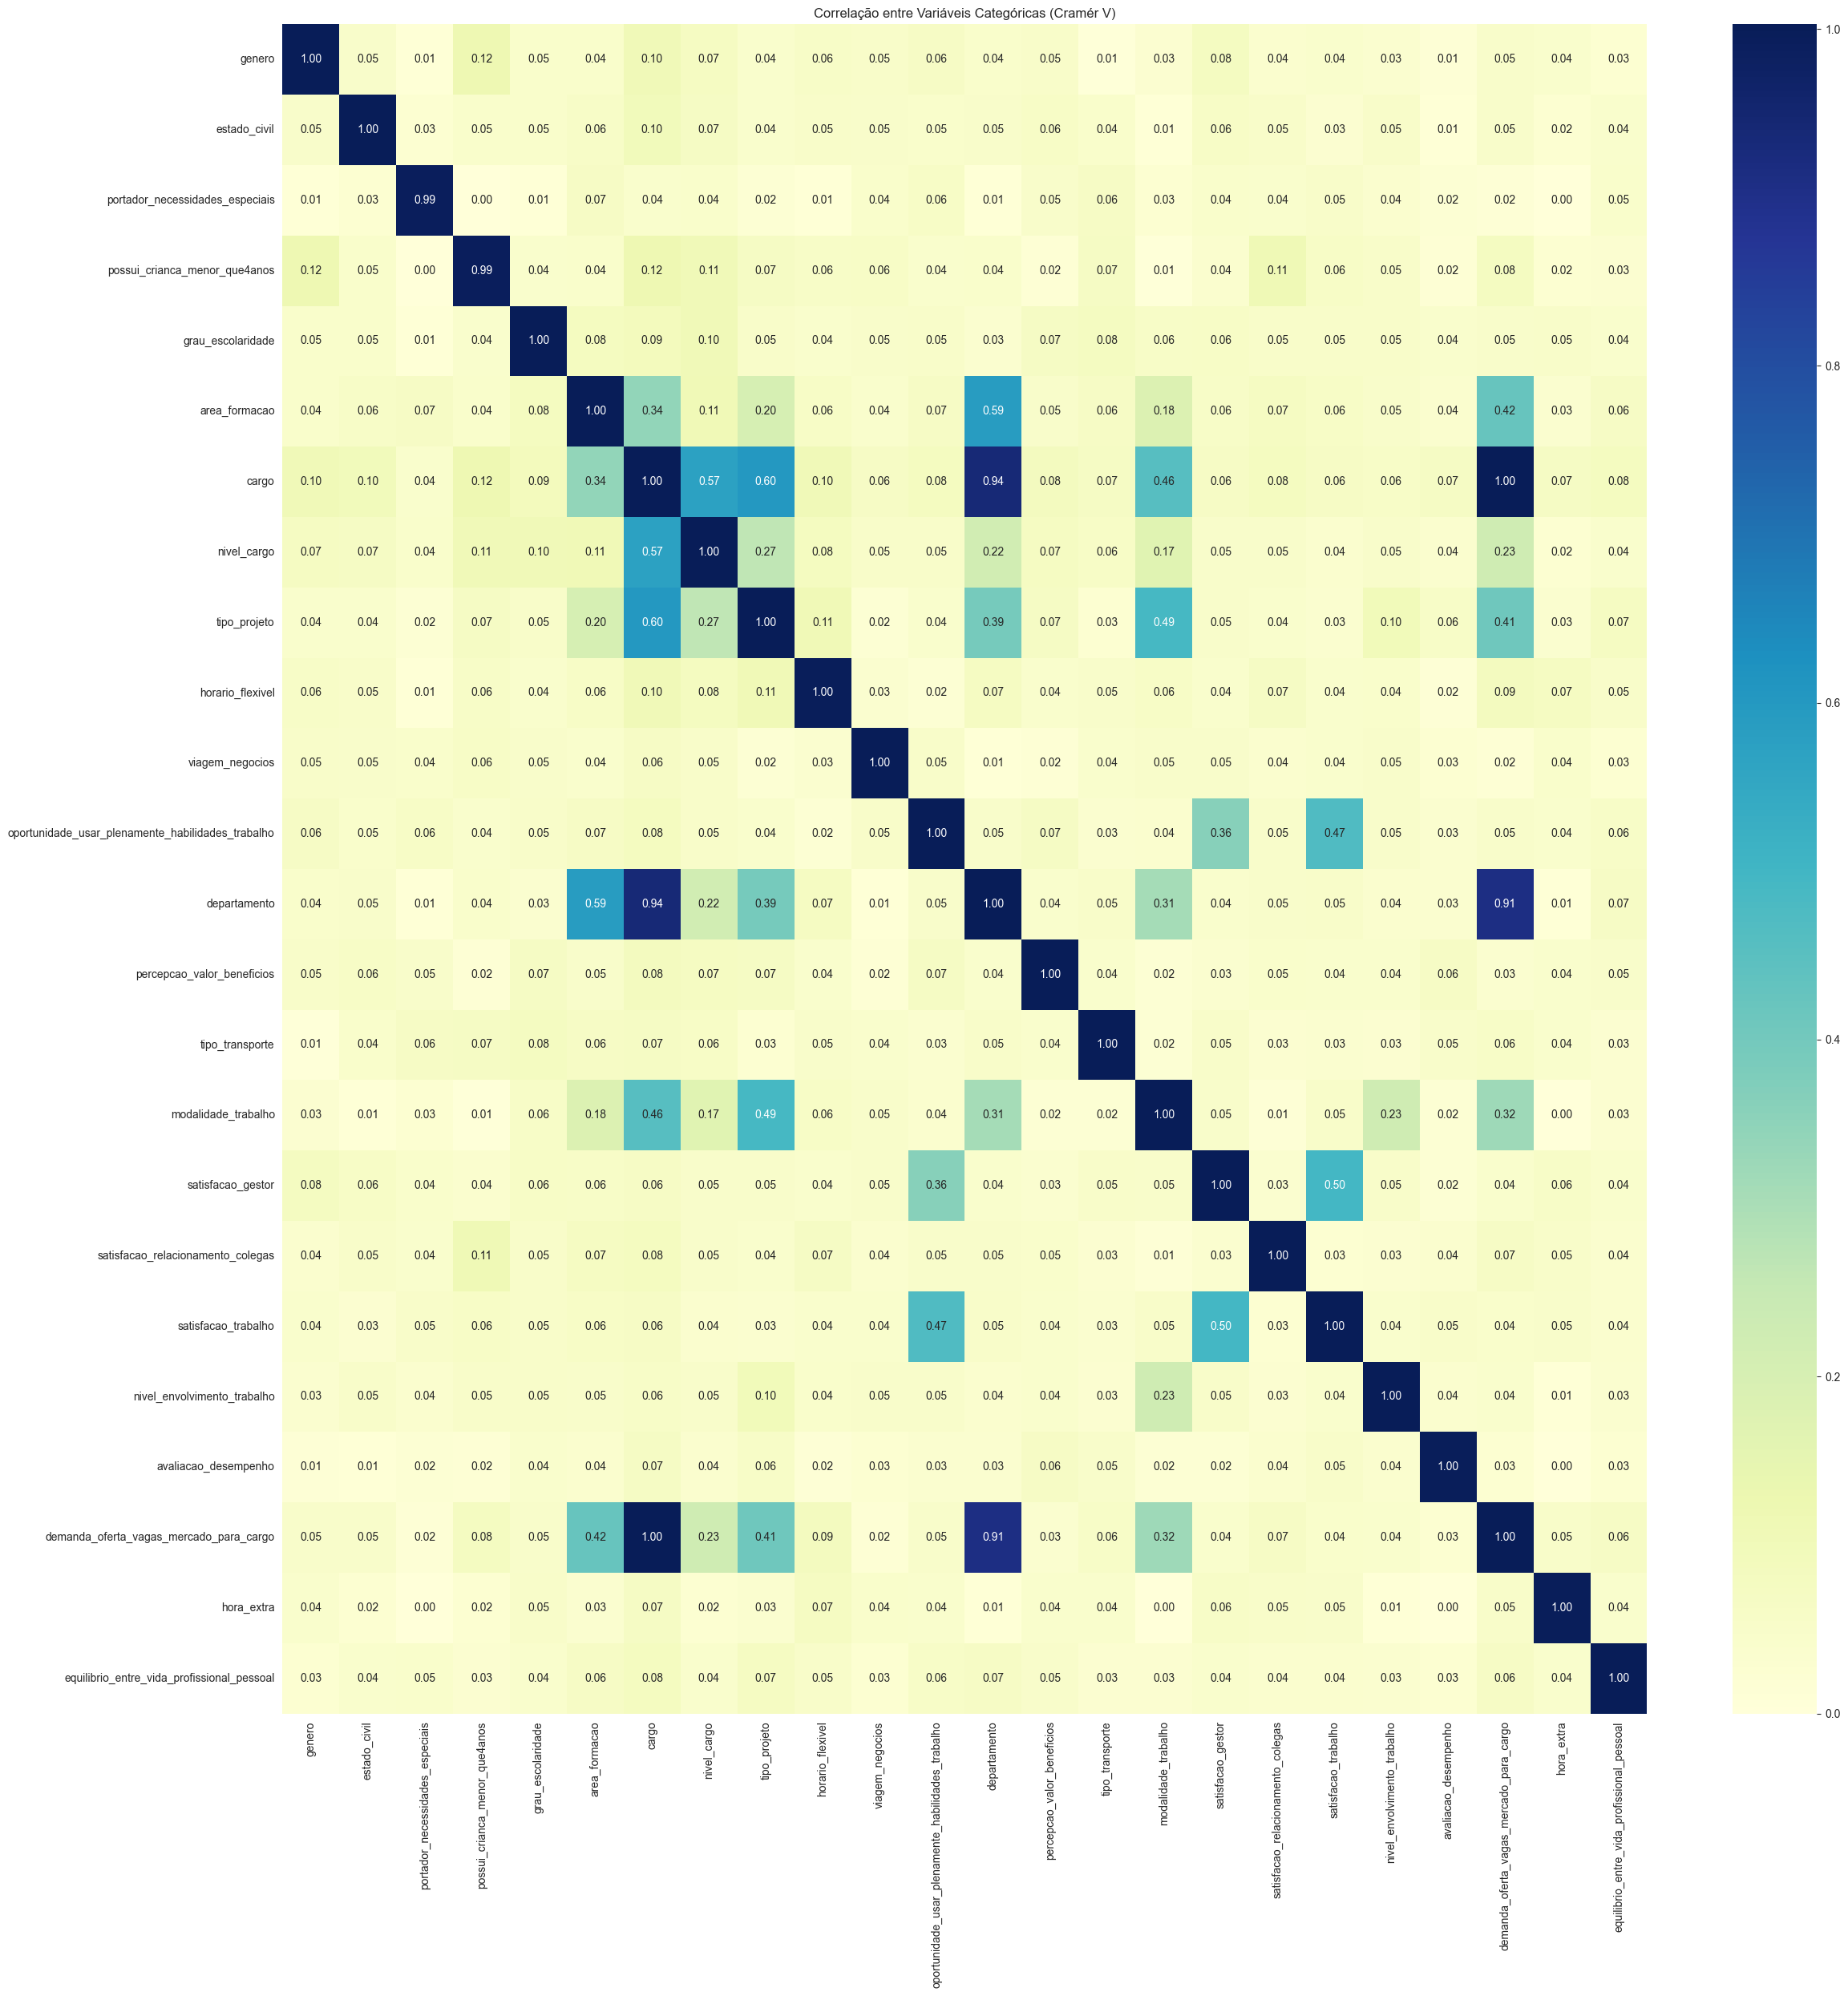

In [46]:
# Calculating Cramer's V for all combinations of categorical variables
variaveis_categoricas = ['genero','estado_civil','portador_necessidades_especiais',
                         'possui_crianca_menor_que4anos','grau_escolaridade','area_formacao',
                         'cargo','nivel_cargo','tipo_projeto','horario_flexivel','viagem_negocios',
                         'oportunidade_usar_plenamente_habilidades_trabalho','departamento',
                         'percepcao_valor_beneficios','tipo_transporte','modalidade_trabalho',
                         'satisfacao_gestor','satisfacao_relacionamento_colegas','satisfacao_trabalho',
                         'nivel_envolvimento_trabalho','avaliacao_desempenho','demanda_oferta_vagas_mercado_para_cargo',
                         'hora_extra','equilibrio_entre_vida_profissional_pessoal']

# Creating an empty array to store the results
resultados = []

# Calculating Cramer's V for all combinations
for var1 in variaveis_categoricas:
    linha = []
    for var2 in variaveis_categoricas:
        v = cramer_v(cat_attributes[var1], cat_attributes[var2])
        linha.append(v)
    resultados.append(linha)

# Creating the DataFrame with the results
d = pd.DataFrame(resultados,
                 columns=variaveis_categoricas,
                 index=variaveis_categoricas)

# Visualizing the correlation matrix
plt.figure(figsize=(25, 25))
sns.heatmap(d, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Correlação entre Variáveis Categóricas (Cramér V)')
plt.tight_layout()
plt.show()

# 8.0 Pré-processamento de dados

## 8.1 Carregando conjunto de dados

In [47]:
# loads data set
df_employee = pd.read_csv('colaboradores_feature_engineering.csv')

In [48]:
df_employee.sample()

,id,idade,genero,estado_civil,portador_necessidades_especiais,possui_crianca_menor_que4anos,grau_escolaridade,area_formacao,treinamento_ultimo_ano,cargo,...,satisfacao_relacionamento_colegas,satisfacao_trabalho,nivel_envolvimento_trabalho,avaliacao_desempenho,absenteismo,hora_extra,equilibrio_entre_vida_profissional_pessoal,demanda_oferta_vagas_mercado_para_cargo,diferenca_salarial_com_mercado_para_mesmo_cargo_nivel_experiencia,demissao_antes_atingir_break_even_acumulado
930,93dfba6d-586c-42fa-ba77-b9beafb79b8f,51,Masculino,Divorciado,Nao,Nao,Especializacao,Bioinformatica,3,Diretor(a) de Operacoes,...,Muito Alto,Medio,Baixo,Excelente,0,Nao,Melhor,Alto,-3132.4,Nao


## 8.2 Separando tipos de dados

In [49]:
# gets the target var
target_var = df_employee[[VARIAVEL_ALVO]]

# gets only numerical attributes
num_attributes = df_employee.select_dtypes(include=['int64', 'float64'])

# gets only binary attributes
binary_attributes = df_employee[['genero', 'portador_necessidades_especiais', 'possui_crianca_menor_que4anos', 'horario_flexivel', 'hora_extra']]

# gets only categorical attributes
cat_attributes = df_employee.select_dtypes(exclude=['int64', 'float64'])

# drops the target var and binary attribute
cat_attributes.drop([VARIAVEL_ALVO,'genero', 'portador_necessidades_especiais', 'possui_crianca_menor_que4anos', 'horario_flexivel', 'hora_extra'], axis=1, inplace=True)

## 8.3 Normalização

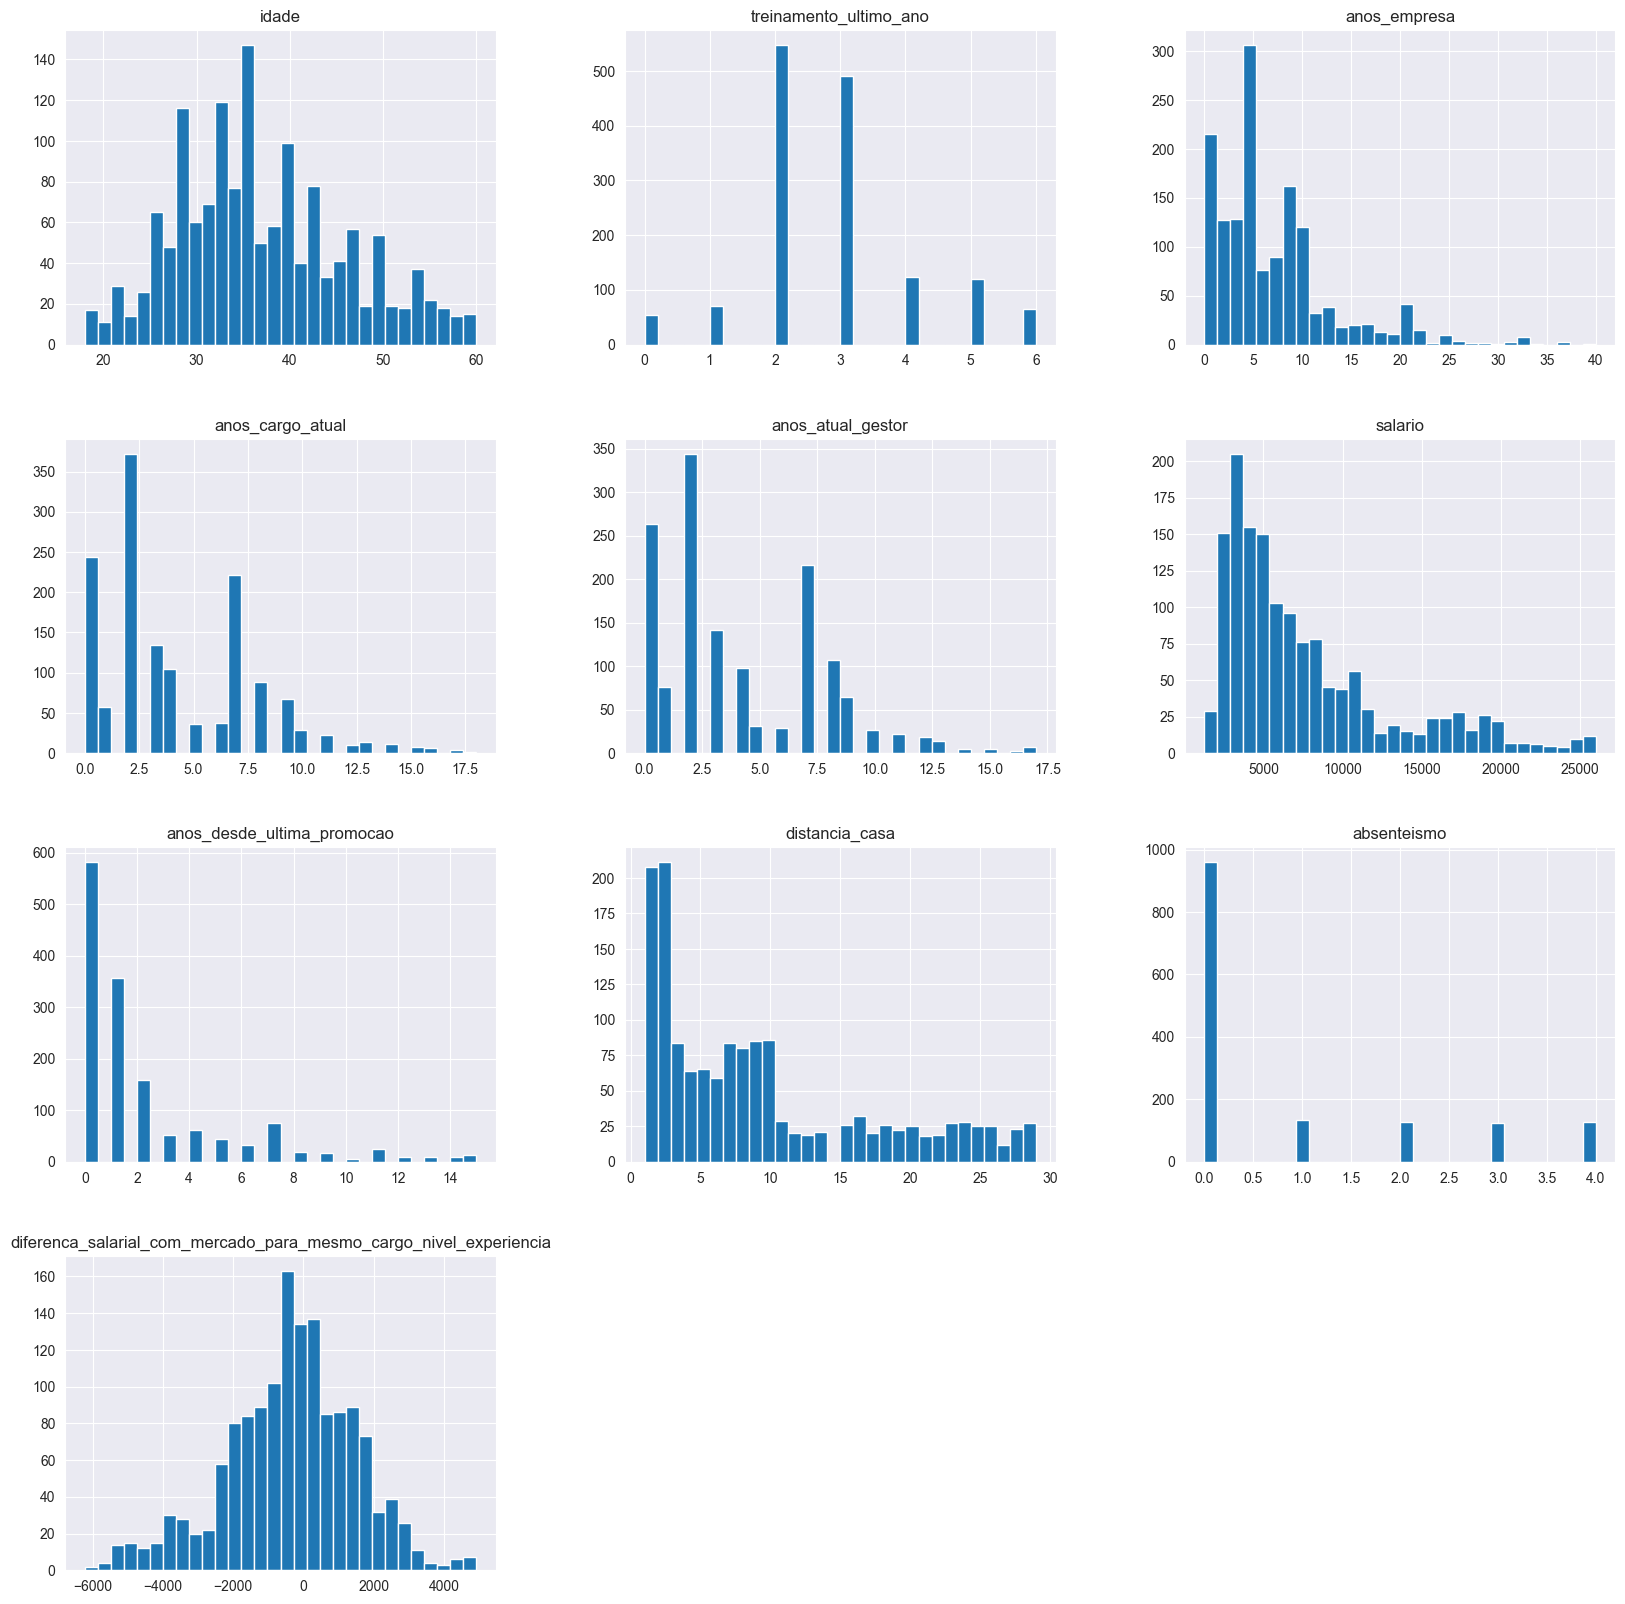

In [50]:
# plots a histogram for all numerical attributes
_ = num_attributes.hist(bins=30, figsize=(20,20))

## 8.4 Escala de variáveis numéricas

In [51]:
# instantiates the classes
mms = MinMaxScaler()

In [52]:
# we need to scale the data because the range of variables vary a lot within them
# treat the features equally
scaled_numerical = mms.fit_transform(num_attributes)

In [53]:
# gets the Data Frame version of numerical scaled for later manipulation
df_scaled_numerical = pd.DataFrame(scaled_numerical)

# renaming the columns of result Data Frame
df_scaled_numerical.columns = num_attributes.columns

## 8.5 Transformação

### 8.5.1 Codificação de atributos binários e alvo

In [54]:
# creates an empty DataFrame
df_binary_att_encoded = pd.DataFrame()

df_binary_att_encoded['genero'] = binary_attributes['genero'].apply(lambda x: 1 if x == 'Masculino'
                                                                    else 0)
df_binary_att_encoded['portador_necessidades_especiais'] = binary_attributes['portador_necessidades_especiais'].apply(lambda x: 1 if x == 'Sim'
                                                                                                                        else 0)
df_binary_att_encoded['possui_crianca_menor_que4anos'] = binary_attributes['possui_crianca_menor_que4anos'].apply(lambda x: 1 if x == 'Sim'
                                                                                                                    else 0)
df_binary_att_encoded['horario_flexivel'] = binary_attributes['horario_flexivel'].apply(lambda x: 1 if x == 'Sim'
                                                                                        else 0)
df_binary_att_encoded['hora_extra'] = binary_attributes['hora_extra'].apply(lambda x: 1 if x == 'Sim'
                                                                                    else 0)
# encondes target_var attrition
target_var.loc[:, VARIAVEL_ALVO] = (
    target_var[VARIAVEL_ALVO]
    .apply(lambda x: 1 if x == 'Sim' else 0)
)

### 8.5.2 Atributos categóricos de codificação de frequência

Como os atributos categóricos têm muitos valores únicos, não é recomendável codificá-los de uma só vez, pois a dimensão do nosso conjunto de dados aumentaria muito. Portanto, podemos evitar isso fazendo a codificação de frequência.

In [55]:
# resets the index
cat_attributes.reset_index(drop=True, inplace=True)

In [56]:
# frequency encodes categorical vars
cat_attr_freq_encoded = get_encoded_frequencies(cat_attributes)

## 8.6 Unificando tudo

In [57]:
# joins scaled with encoded attributes
df_employee_prep = pd.concat([target_var, df_scaled_numerical, df_binary_att_encoded, cat_attr_freq_encoded], axis=1)

## 8.7 Checkpoint

In [58]:
# saves data set current state
df_employee_prep.to_csv('colaboradores_prep.csv', index=False)

# 9.0 Seleção de recursos (Feature selection)

A seção de feature selection é meramente informativa, sendo que não está a ser utilizado somente os atributos selecionados nas etapas posteriores de modelagem

## 9.1 Carregando conjunto de dados

In [59]:
# loads data set
df_employee = pd.read_csv('colaboradores_prep.csv')

## 9.2 Boruta como seletor de features

In [60]:
# define training test data for Boruta
X = df_employee.drop(VARIAVEL_ALVO, axis=1).values
Y = df_employee[VARIAVEL_ALVO].values.ravel()

In [61]:
# define RandomForestClassifier
# uses all cores from CPU
rf_clf = RandomForestClassifier(n_jobs=-1)

In [62]:
# define Boruta
boruta = BorutaPy(rf_clf, n_estimators='auto', verbose=2, random_state=SEED).fit(X, Y)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	28
Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	28
Iteration: 	10 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	28
Iteration: 	11 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	28
Iteration: 	12 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	28
Iteration: 	13 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	28
Iteration: 	14 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	28
Iteration: 	15 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	28
Iteration: 	16 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	28
I

## 9.3 Melhores features do Boruta

In [63]:
# gets the ranked list of features
cols_selected = boruta.support_.tolist()
df_employee.drop(VARIAVEL_ALVO, axis=1).iloc[:, cols_selected].columns.to_list()

['anos_empresa',
 'anos_cargo_atual',
 'anos_atual_gestor',
 'salario',
 'diferenca_salarial_com_mercado_para_mesmo_cargo_nivel_experiencia',
 'modalidade_trabalho']

# 10. Modelagem de aprendizado de máquina

### **Tagert variable:** `demissao_antes_atingir_break_even_acumulado` (`0` = No. Employee may not leave ; `1` = Yes. Employee may leave)

## 10.1 Carregando conjunto de dados

In [64]:
# loads data set
df_employee = pd.read_csv('colaboradores_prep.csv')

## 10.2 Dividir o conjunto de dados em treinamento e teste

In [65]:
# creates arrays for the features and target variable
X = df_employee.drop(VARIAVEL_ALVO, axis=1).copy()
Y = df_employee[VARIAVEL_ALVO].copy()

# splits into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=SEED, stratify=Y)


## 10.3 Balanceamento de dados para treinamento

In [66]:
# counts the number of classes before oversampling
counter = Counter(y_train)
print('Antes do balanceamento:', counter)

# defines the resampler
resampler = SMOTETomek(random_state=SEED, n_jobs=-1)

# transforms the data set
X_balanced, y_balanced = resampler.fit_resample(X_train, y_train)

# counts the number of classes after oversampling
counter = Counter(y_balanced)
print('Depois do balanceamento:', counter)

Antes do balanceamento: Counter({0: 1079, 1: 97})
Depois do balanceamento: Counter({0: 1079, 1: 1079})


## 10.4 Training the models and getting the performance metrics

In [67]:
# sets the threshold
THRESHOLD = 0.50

# defines the classifiers
classifiers = [LogisticRegression(random_state=SEED),
               RandomForestClassifier(random_state=SEED),
               XGBClassifier(random_state=SEED),
               LGBMClassifier(random_state=SEED, n_jobs=-1)]

# calculates classifiers performance
df_performance = get_classifiers_performance(X_balanced, X_test,
                                                np.ravel(y_balanced), np.ravel(y_test),
                                                THRESHOLD, classifiers)

Training LogisticRegression...
Training RandomForestClassifier...
Training XGBClassifier...
Training LGBMClassifier...
[LightGBM] [Info] Number of positive: 1079, number of negative: 1079
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7175
[LightGBM] [Info] Number of data points in the train set: 2158, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [68]:
# highlight max values for each column
df_performance.style.highlight_max(color='darkorange')

,model,precision,recall,f1-Score,ROC AUC,accuracy,cohen kappa
0,LogisticRegression,0.345455,0.791667,0.481013,0.930710,0.860544,0.414456
2,RandomForestClassifier,0.857143,0.500000,0.631579,0.965895,0.952381,0.608000
4,XGBClassifier,1.000000,0.750000,0.857143,0.978704,0.979592,0.846395
6,LGBMClassifier,0.850000,0.708333,0.772727,0.984722,0.965986,0.754509


## 10.5 Confusion Matrix

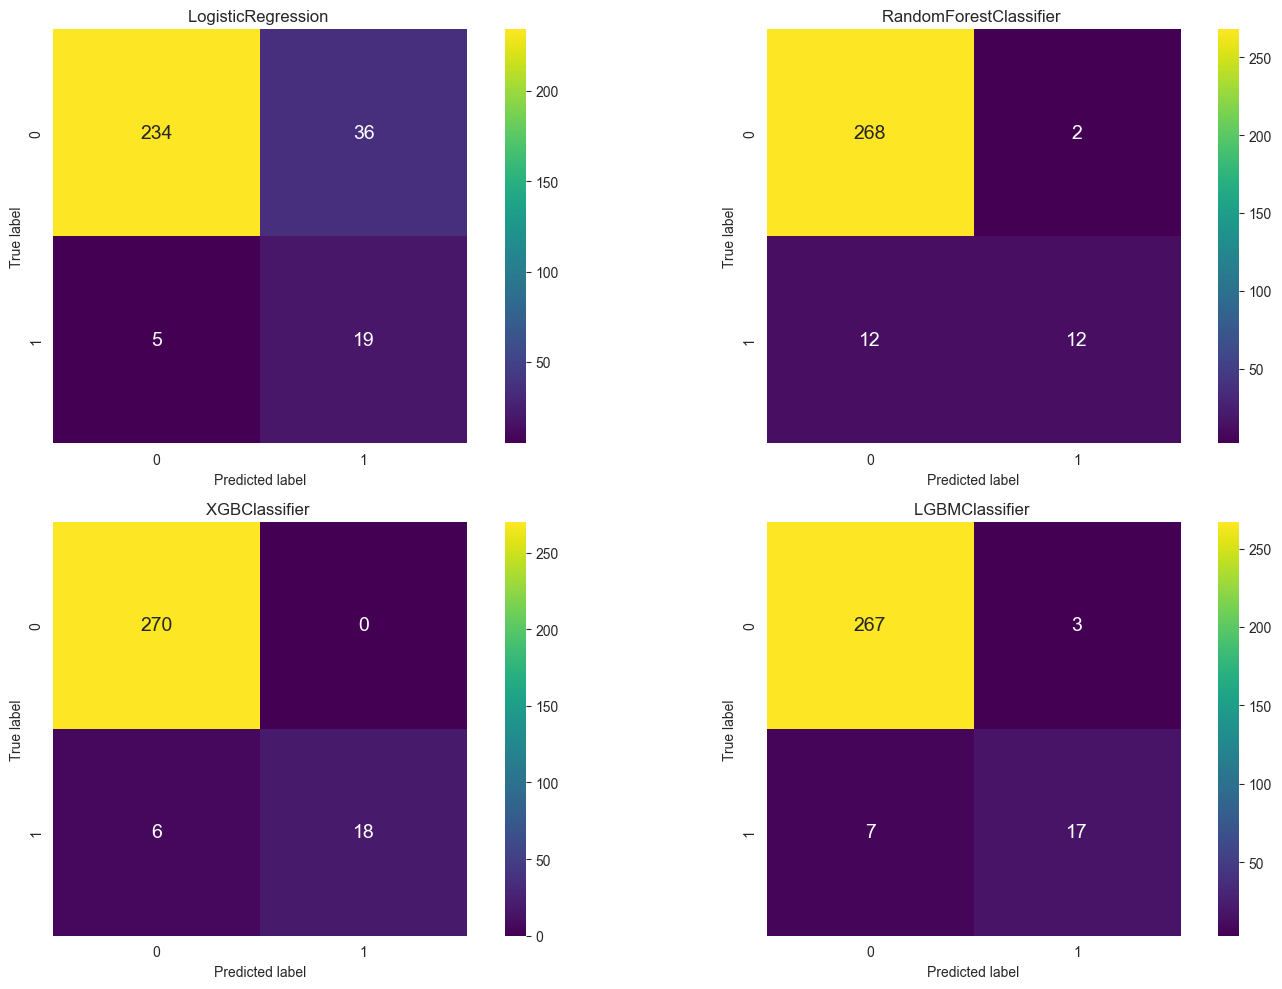

In [69]:
plot_multiple_confusion_matrices(2, 2, X_test, y_test, classifiers, THRESHOLD)

## 10.6 Distribuição de probabilidade

In [70]:
# instantiates the classifiers
lr_clf = LogisticRegression(random_state=SEED)
rf_clf = RandomForestClassifier(random_state=SEED, n_jobs=-1)
xgb_clf = XGBClassifier(random_state=SEED, n_jobs=-1)
lgbm_clf = LGBMClassifier(random_state=SEED, n_jobs=-1)

# trains the classifiers
lr_clf.fit(X_balanced, y_balanced)
rf_clf.fit(X_balanced, y_balanced)
xgb_clf.fit(X_balanced, y_balanced)
lgbm_clf.fit(X_balanced, y_balanced)

# store the predicted probabilities for class 1
y_pred_lr_prob = lr_clf.predict_proba(X_test)[:, 1]
y_pred_rf_prob = rf_clf.predict_proba(X_test)[:, 1]
y_pred_xgb_prob = xgb_clf.predict_proba(X_test)[:, 1]
y_pred_lgbm_prob = lgbm_clf.predict_proba(X_test)[:, 1]

[LightGBM] [Info] Number of positive: 1079, number of negative: 1079
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7175
[LightGBM] [Info] Number of data points in the train set: 2158, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


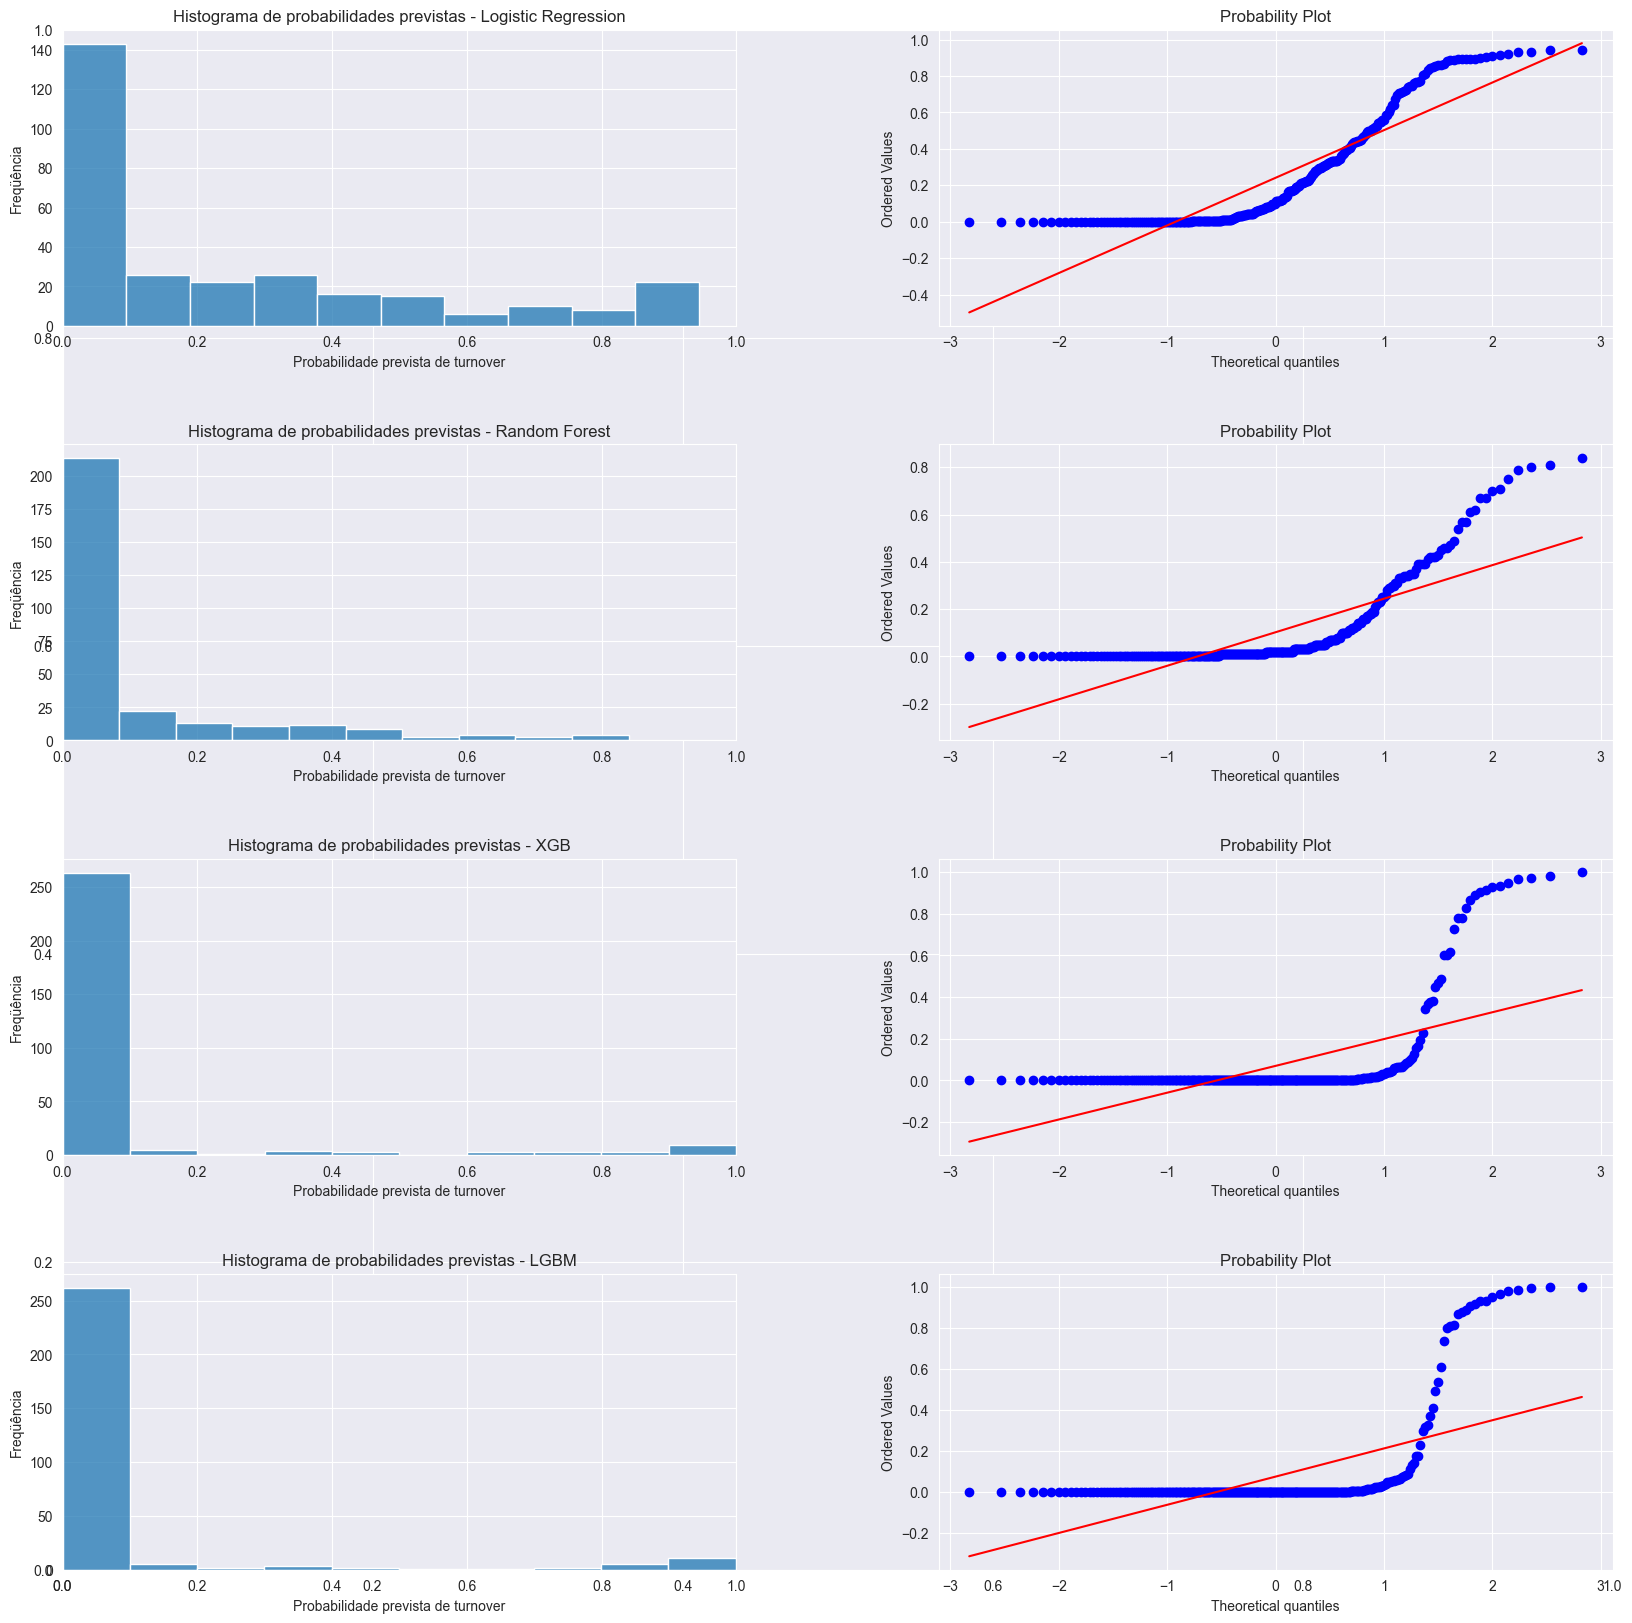

In [71]:
# set axes
fig, ax = plt.subplots()

# set fig size
ax.figure.set_size_inches(20, 20)

# plot histogram
plt.subplot(4, 2, 1)
ax = sns.histplot(y_pred_lr_prob, bins=10)

# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histograma de probabilidades previstas - Logistic Regression')
plt.xlabel('Probabilidade prevista de turnover')
plt.ylabel('Freqüência')

# plot probability
plt.subplot(4, 2, 2)
ax = stats.probplot(y_pred_lr_prob, plot=plt)


# plot histogram
plt.subplot(4, 2, 3)
ax = sns.histplot(y_pred_rf_prob, bins=10)

# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histograma de probabilidades previstas - Random Forest')
plt.xlabel('Probabilidade prevista de turnover')
plt.ylabel('Freqüência')

# plot probability
plt.subplot(4, 2, 4)
ax = stats.probplot(y_pred_rf_prob, plot=plt)


# plot histogram
plt.subplot(4, 2, 5)
ax = sns.histplot(y_pred_xgb_prob, bins=10)

# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histograma de probabilidades previstas - XGB')
plt.xlabel('Probabilidade prevista de turnover')
plt.ylabel('Freqüência')

# plot probability
plt.subplot(4, 2, 6)
ax = stats.probplot(y_pred_xgb_prob, plot=plt)


# plot histogram
plt.subplot(4, 2, 7)
ax = sns.histplot(y_pred_lgbm_prob, bins=10)

# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histograma de probabilidades previstas - LGBM')
plt.xlabel('Probabilidade prevista de turnover')
plt.ylabel('Freqüência')

# plot probability
plt.subplot(4, 2, 8)
ax = stats.probplot(y_pred_lgbm_prob, plot=plt)

plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.4)

# displays the plot
plt.show()

## 10.7 Relatório de classificação

In [72]:
# makes predictions
y_pred_lr = lr_clf.predict(X_test)
y_pred_rf = rf_clf.predict(X_test)
y_pred_xgb = xgb_clf.predict(X_test)
y_pred_lgbm = lgbm_clf.predict(X_test)

print('Relatório de Classificação para ' + type(lr_clf).__name__)
print(classification_report(y_test, y_pred_lr))

print('Relatório de Classificação para ' + type(rf_clf).__name__)
print(classification_report(y_test, y_pred_rf))

print('Relatório de Classificação para ' + type(xgb_clf).__name__)
print(classification_report(y_test, y_pred_xgb))

print('Relatório de Classificação para ' + type(lgbm_clf).__name__)
print(classification_report(y_test, y_pred_lgbm))

Relatório de Classificação para LogisticRegression
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       270
           1       0.35      0.79      0.48        24

    accuracy                           0.86       294
   macro avg       0.66      0.83      0.70       294
weighted avg       0.93      0.86      0.88       294

Relatório de Classificação para RandomForestClassifier
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       270
           1       0.86      0.50      0.63        24

    accuracy                           0.95       294
   macro avg       0.91      0.75      0.80       294
weighted avg       0.95      0.95      0.95       294

Relatório de Classificação para XGBClassifier
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       270
           1       1.00      0.75      0.86        24

    accuracy                  

Outra maneira de nos ajudar a decidir é o `Relatório de Classificação`. Neste projeto, buscamos uma alta taxa de recall para a classe `1`.

# 11.0 Ajuste do melhor modelo

## 11.1 Ajuste de hiperparâmetros

In [73]:
# instantiates classifier
chosen_clf = None
match MODEL_SELECTED:
    case "LogisticRegression":
        chosen_clf = LogisticRegression(random_state=SEED, n_jobs=-1)
    case "RandomForestClassifier":
        chosen_clf = RandomForestClassifier(random_state=SEED, n_jobs=-1)
    case "XGBClassifier":
        chosen_clf = XGBClassifier(random_state=SEED, n_jobs=-1)
    case "LGBMClassifier":
        chosen_clf = LGBMClassifier(random_state=SEED, n_jobs=-1)
    case _:
        print(f"O modelo '{MODEL_SELECTED}' não é uma opção válida!")

In [74]:
# set up space dictionary with specified hyperparameters
match MODEL_SELECTED:
    case "LogisticRegression":
        param_dist = [
            {
                'penalty': ['l1'],
                'solver': ['liblinear', 'saga'],
                'C': loguniform(0.001, 100),
                'class_weight': ['balanced', None]
            },
            {
                'penalty': ['l2'],
                'solver': ['lbfgs', 'liblinear', 'saga'],
                'C': loguniform(0.001, 100),
                'class_weight': ['balanced', None]
            },
            {
                'penalty': ['elasticnet'],
                'solver': ['saga'],
                'C': loguniform(0.001, 100),
                'l1_ratio': uniform(0, 1),
                'class_weight': ['balanced', None]
            }
        ]
    case "RandomForestClassifier":
        param_dist = {
            'n_estimators': randint(100, 1200),
            'max_depth': [None] + list(range(10, 111)),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 20),
            'max_features': ['sqrt', 'log2', None],
            'criterion': ['gini', 'entropy'],
            'bootstrap': [True, False],
            'class_weight': ['balanced', 'balanced_subsample', None]
        }
    case "XGBClassifier":
        param_dist = {
            'learning_rate': uniform(0.01, 0.3),
            'n_estimators': randint(100, 1500),
            'max_depth': randint(3, 12),
            'subsample': uniform(0.5, 0.5),
            'colsample_bytree': uniform(0.5, 0.5),
            'gamma': uniform(0, 0.5),
            'reg_alpha': uniform(0, 1),
            'reg_lambda': uniform(0, 1)
        }
    case "LGBMClassifier":
        param_dist = {
            'num_leaves': randint(20, 150),
            'learning_rate': uniform(0.01, 0.3),
            'n_estimators': randint(100, 2000),
            'max_depth': randint(5, 20),
            'colsample_bytree': uniform(0.5, 0.5),
            'subsample': uniform(0.5, 0.5),
            'reg_alpha': uniform(0, 1),
            'reg_lambda': uniform(0, 1)
        }
    case _:
        print(f"O modelo '{MODEL_SELECTED}' não é uma opção válida!")

In [75]:
# prepares RandomizedSearchCV object
chosen_clf_cv = RandomizedSearchCV(
    chosen_clf,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='recall',
    random_state=SEED,
    n_jobs=-1
)

In [76]:
# fits the RandomizedSearchCV object
chosen_clf_cv.fit(X_balanced, y_balanced)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample',
                                                         None],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 11, 12, 13, 14,
                                                      15, 16, 17, 18, 19, 20,
                                                      21, 22, 23, 24, 25, 26,
                                                      27, 28, 29, 30, 31, 32,
                                                      33, 34, 35, 36, 37, 38, ...],
                                        'max_...sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000229CC22E0D0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000229CC22E490>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000229CC453380>},
                   random_state=42, scoring='recall')

In [77]:
# best estimator
chosen_clf_cv.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=100, max_features=None,
                       min_samples_leaf=15, min_samples_split=13,
                       n_estimators=931, n_jobs=-1, random_state=42)

## 11.2 Previsões e Métricas

In [78]:
# Print the tuned parameters and score
print("\nParâmetros ajustados: {}".format(chosen_clf_cv.best_params_))
print("\nMelhor pontuação: {:.4f}".format(chosen_clf_cv.best_score_))


Parâmetros ajustados: {'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 100, 'max_features': None, 'min_samples_leaf': 15, 'min_samples_split': 13, 'n_estimators': 931}

Melhor pontuação: 0.9759


In [79]:
# sets the threshold
# THRESHOLD = 0.5

# extract the best estimator
clf_best_model = chosen_clf_cv.best_estimator_

# predicts probabilities
clf_best_model_probs = clf_best_model.predict_proba(X_test)


# calculates classifiers performance
df_performance = get_classifiers_performance(X_balanced, X_test,
                                             np.ravel(y_balanced), np.ravel(y_test),
                                             THRESHOLD, [clf_best_model])

df_performance

Training RandomForestClassifier...


,model,precision,recall,f1-Score,ROC AUC,accuracy,cohen kappa
0,RandomForestClassifier,0.7,0.875,0.777778,0.985957,0.959184,0.755611


## 11.3 Curvas PR e ROC

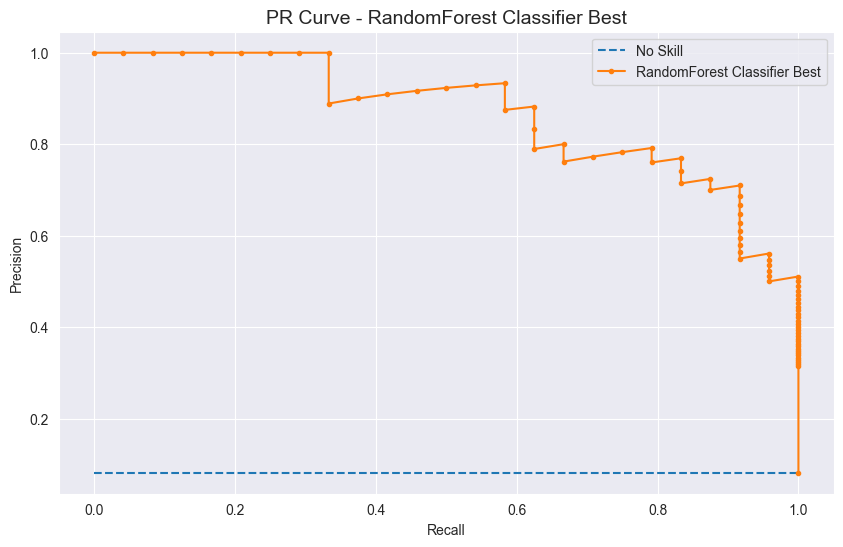

In [80]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(10, 6)

# plots PR AUC
clf_name = ''
match MODEL_SELECTED:
    case "LogisticRegression":
        clf_name = 'Logistic Regression Best'
    case "RandomForestClassifier":
        clf_name = 'RandomForest Classifier Best'
    case "XGBClassifier":
        clf_name = 'XGB Classifier Best'
    case "LGBMClassifier":
        clf_name = 'LGBM Classifier Best'
    case _:
        print(f"O modelo '{MODEL_SELECTED}' não é uma opção válida!")

plot_pr_auc(y_test, clf_best_model_probs, clf_name)

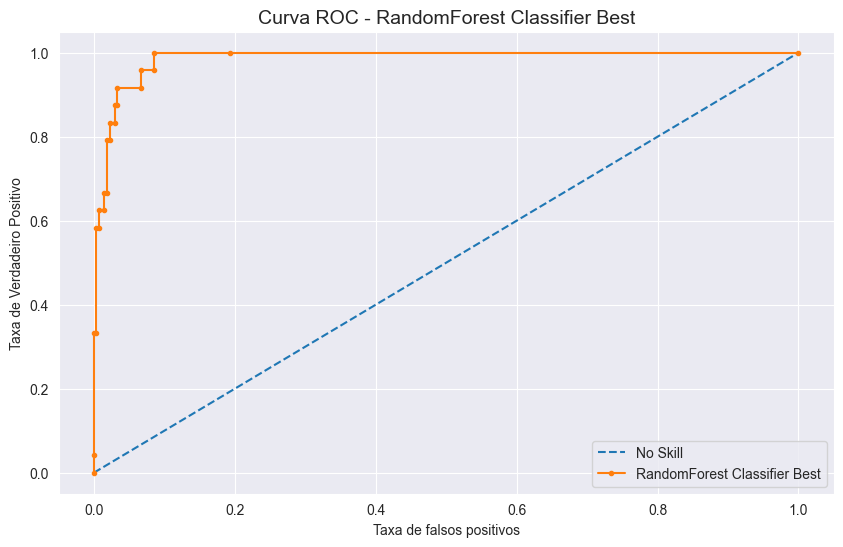

In [81]:
# sets the plot size
plt.figure(figsize=(10,6))

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
fpr, tpr, _ = roc_curve(y_test, clf_best_model_probs[:, 1])

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label=clf_name)

# axis labels
plt.xlabel('Taxa de falsos positivos')
plt.ylabel('Taxa de Verdadeiro Positivo')

# title
plt.title(f'Curva ROC - {clf_name}', fontsize=14)

# show the legend
plt.legend()

# show the plot
plt.show()

## 11.4 Matriz de Confusão

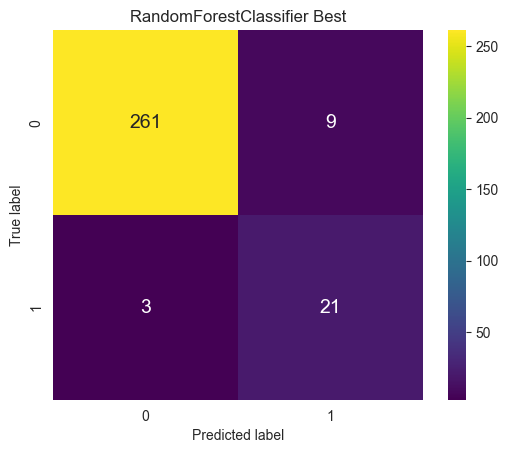

In [82]:
# keeps probabilities for the positive outcome only
df_clf_bm_probs = pd.DataFrame(clf_best_model_probs[:, 1], columns = ['prob_default'])

# applied the threshold
y_pred_bm = df_clf_bm_probs['prob_default'].apply(lambda x: 1 if x > THRESHOLD else 0)

plot_single_confusion_matrix(y_test, y_pred_bm, clf_best_model, 'Best')

# displays plot
plt.show()

## 11.5 Pontuação de validação cruzada

In [83]:
print(f'Proporção de negativos no conjunto de dados completo: {Y.value_counts(normalize=True).to_dict()[0]}')
print(f'Proporção de positivos no conjunto de dados completo: {Y.value_counts(normalize=True).to_dict()[1]}')

Proporção de negativos no conjunto de dados completo: 0.917687074829932
Proporção de positivos no conjunto de dados completo: 0.08231292517006802


Como observado, o conjunto de dados completo original está desequilibrado, então precisaremos adotar o `StratifiedKFold` como nossa estratégia de K-folding para validação cruzada.

In [84]:
# Crie o pipeline completo
pipeline = ImbPipeline([
    ('smote', resampler),
    ('classifier', clf_best_model)
])

# defines the cross validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

In [85]:
# calculates the cross validation scores
cv_scores = cross_val_score(pipeline, X, np.ravel(Y), cv = cv, scoring='precision', n_jobs=-1)

# prints the average accuracy and standard deviation of the scores
print("Average precision: %0.4f (+/- %0.4f)" % (cv_scores.mean(),
                                              cv_scores.std() * 2))

# calculates the cross validation scores
cv_scores = cross_val_score(pipeline, X, np.ravel(Y), cv = cv, scoring='recall', n_jobs=-1)

# prints the average accuracy and standard deviation of the scores
print("\nAverage recall: %0.4f (+/- %0.4f)" % (cv_scores.mean(),
                                              cv_scores.std() * 2))

# calculates the cross validation scores
cv_scores = cross_val_score(pipeline, X, np.ravel(Y), cv = cv, scoring='roc_auc', n_jobs=-1)

# prints the average accuracy and standard deviation of the scores
print("\nAverage ROC AUC: %0.4f (+/- %0.4f)" % (cv_scores.mean(),
                                              cv_scores.std() * 2))

Average precision: 0.6418 (+/- 0.1023)

Average recall: 0.8353 (+/- 0.2210)

Average ROC AUC: 0.9776 (+/- 0.0200)


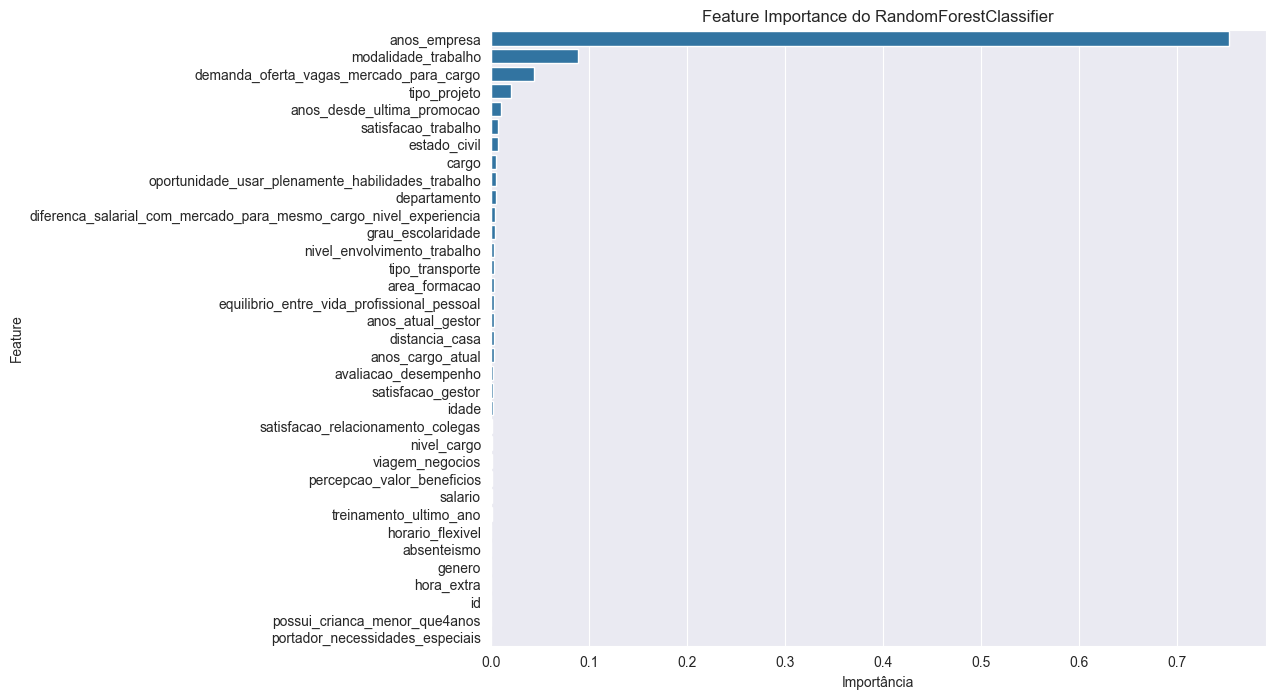

In [86]:
match MODEL_SELECTED:
    case "LogisticRegression":
        # Extrai os coeficientes e calcula o valor absoluto
        # Usamos *.coef_[0] porque este é um problema de classificação binária
        importance = np.abs(pipeline.named_steps['classifier'].coef_[0])

        # Cria um DataFrame para melhor visualização
        feature_importances_lr = pd.DataFrame({'feature': X_balanced.columns, 'importance': importance})

        # Ordena as features pela importância
        feature_importances_lr = feature_importances_lr.sort_values('importance', ascending=False)

        # Plota o gráfico de importância das features
        plt.figure(figsize=(10, 8))
        sns.barplot(x='importance', y='feature', data=feature_importances_lr)
        plt.title('Feature Importance da Logistic Regression (Valor Absoluto dos Coeficientes)')
        plt.xlabel('Magnitude do Coeficiente')
        plt.ylabel('Feature')
        plt.show()
    case "RandomForestClassifier" | "XGBClassifier" | "LGBMClassifier":
        # Extrai a importância das features
        importances = pipeline.named_steps['classifier'].feature_importances_

        # Cria um DataFrame para melhor visualização
        feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})

        # Ordena as features pela importância
        feature_importances = feature_importances.sort_values('importance', ascending=False)

        # Plota o gráfico de importância das features
        plt.figure(figsize=(10, 8))
        sns.barplot(x='importance', y='feature', data=feature_importances)
        plt.title(f'Feature Importance do {MODEL_SELECTED}')
        plt.xlabel('Importância')
        plt.ylabel('Feature')
        plt.show()
    case _:
        print(f"O modelo '{MODEL_SELECTED}' não é uma opção válida!")

# 12.0 Desempenho no mundo real

Desempenho do modelo na amostragem separada para validação

## 12.1 Métricas principais

In [87]:
# calculates classifiers performance
df_performance = get_classifiers_performance(X_balanced, X_test,
                                             np.ravel(y_balanced), np.ravel(y_test),
                                             THRESHOLD, [clf_best_model])

df_performance

Training RandomForestClassifier...


,model,precision,recall,f1-Score,ROC AUC,accuracy,cohen kappa
0,RandomForestClassifier,0.7,0.875,0.777778,0.985957,0.959184,0.755611


Como estamos lidando com um conjunto de dados desbalanceado, a métrica mais relevante, neste caso, é o **recall** (`1.0`), que é usado **quando os Falsos Negativos são cruciais**. Para este projeto, os Falsos Negativos são cruciais, pois a perda dessas pessoas pode levar a prejuízos financeiros para a empresa.

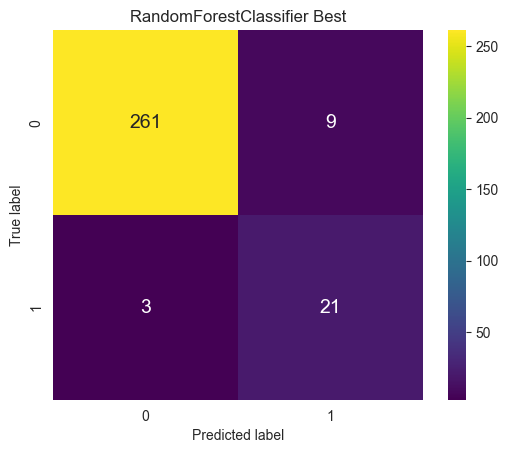

In [88]:
# sets the threshold
THRESHOLD = 0.50

# keeps probabilities for the positive outcome only
df_clf_bm_probs = pd.DataFrame(clf_best_model_probs[:, 1], columns = ['prob_default'])

# applied the threshold
y_pred_clf_bm = df_clf_bm_probs['prob_default'].apply(lambda x: 1 if x > THRESHOLD else 0)

plot_single_confusion_matrix(y_test, y_pred_clf_bm, clf_best_model, 'Best')

# displays plot
plt.show()

Modelo de matriz de confusão e o melhor-pior cenário.

<img src="img/confusion-matrix.png" width="70%">

# 13.0 Testando as previsões

## 13.1 Falsos Negativos & Verdadeiros Positivos

In [89]:
df_X_test = pd.DataFrame(X_test)
df_y_test = pd.DataFrame(y_test)
df_y_pred = pd.DataFrame(y_pred_clf_bm)

df_y_test.columns = ['y_test']
df_y_pred.columns = ['y_pred']

df_test_final = pd.concat([df_y_pred, df_y_test, df_X_test], axis=1)

In [90]:
# false negatives or true postives
df_fn_tp = df_test_final[((df_test_final['y_pred'] == 0) & (df_test_final['y_test'] == 1)) | ((df_test_final['y_pred'] == 1) & (df_test_final['y_test'] == 1))]
df_fn_tp

,y_pred,y_test,idade,treinamento_ultimo_ano,anos_empresa,anos_cargo_atual,anos_atual_gestor,salario,anos_desde_ultima_promocao,distancia_casa,...,percepcao_valor_beneficios,tipo_transporte,modalidade_trabalho,satisfacao_gestor,satisfacao_relacionamento_colegas,satisfacao_trabalho,nivel_envolvimento_trabalho,avaliacao_desempenho,equilibrio_entre_vida_profissional_pessoal,demanda_oferta_vagas_mercado_para_cargo
